### Decision Time of Human-AI Decision / Human Decision - By Reliance Groups and XAI condition

In [9]:
import pandas as pd

reliance_data = pd.read_csv('groups.csv')

# remove 'O23' or user == 'OX30' from the dataset
reliance_data = reliance_data[~reliance_data['ID'].isin(['O23', 'OX30'])]

time_data = pd.read_csv('task-times-by-decision.csv')

# human-ai decision time is timestamp (end_human_ai_decision - end_human_decision_time)
# human decision time is (end_human_decision_time - feedback) or (end_human_decision_time - tutorial_task)

# for every click_start, remove the rows between click_start and tutorial_task

# obtain all indexes of click_start
click_start_indexes = time_data[time_data['event'] == 'click_start'].index
# obtain all indexes of tutorial_task
tutorial_task_indexes = time_data[time_data['event'] == 'tutorial_task'].index

print (click_start_indexes)
print (tutorial_task_indexes)

# save time_data to a new DataFrame and remove the rows between click_start and tutorial_task
filtered_df = time_data.copy()
# drop all rows between click_start and tutorial_task indexes
for i in range(len(click_start_indexes)):
    start_index = click_start_indexes[i]
    end_index = tutorial_task_indexes[i]
    filtered_df.drop(index = range(start_index, end_index), inplace=True)
# Reset index after dropping rows
filtered_df = filtered_df.reset_index(drop=True)

# save the filtered data
filtered_df.to_csv('filtered_task_times.csv', index=False)
time_data = pd.read_csv('filtered_task_times.csv')

def get_XAI(idd):
    if 'X' in idd:
        return 1
    else:
        return 0

def get_spss_data(tracker_results):
    tracker_results['XAI_value'] = tracker_results['ID'].apply(get_XAI)

def get_human_decision_time(row):
    # the row is either feedback or tutorial_task, so we need to get the time of the next row
    # (end_human_decision)
    next_row = time_data.iloc[i+1]
    decision_time = next_row['timestamp'] - row['timestamp'] 
    return decision_time

def get_human_ai_decision_time(row):
    # the row is end_human_decision, so we need to get the time of the next row (end_human_ai_decision)
    next_row = time_data.iloc[i+1]
    decision_time = next_row['timestamp'] - row['timestamp']
    return decision_time

ids = []
human_ai_decision_times = []
human_decision_times = []
tasks = []
task = 1
previous_id = time_data.iloc[0]['ID']
print('Previous ID', previous_id)
print(len(time_data))
# Loop through the data
for i in range(0, len(time_data)-1):
    row = time_data.iloc[i]
    current_id = row['ID']  # current user ID
    # check for human decision time - 1st task of 1st user
    if row['event'] == 'tutorial_task' and current_id == previous_id:
        human_decision_time = get_human_decision_time(row)
        human_decision_times.append(human_decision_time)
        print('Initial: ', task)
    # check for human decision time - subsequent tasks until the last task
    elif row['event'] == 'feedback' and current_id == previous_id and current_id == time_data.iloc[i+1]['ID']:
        human_decision_time = get_human_decision_time(row)
        human_decision_times.append(human_decision_time)    
        task += 1
        print('Human Task: ', task)
    elif row['event'] == 'tutorial_task' and current_id != previous_id:
        human_decision_time = get_human_decision_time(row)
        human_decision_times.append(human_decision_time)
        task = 1
        print('New User: ', task)
    # check for human-ai decision
    elif row['event'] == 'end_human_decision':
        human_ai_decision_time = get_human_ai_decision_time(row)
        human_ai_decision_times.append(human_ai_decision_time)
        ids.append(current_id)
        tasks.append(task)
        print('Task Human-AI: ',  task)
    else:
        continue
    previous_id = current_id

print(len(ids))
print(len(tasks))
print(len(human_decision_times))
print(len(human_ai_decision_times))

# create a new DataFrame with the collected data
output_df = pd.DataFrame({
    'ID': ids,
    'task': tasks,
    'human_decision_time': human_decision_times,
    'human_ai_decision_time': human_ai_decision_times
})

# XAI value
get_spss_data(output_df)
output_df.to_csv('decision_times.csv', index=False)


Int64Index([   0,   54,  108,  162,  216,  270,  324,  378,  432,  486,  540,
             594,  648,  702,  756,  810,  864,  918,  972, 1026, 1080, 1134,
            1188, 1242, 1296, 1350, 1404, 1458, 1512, 1566],
           dtype='int64')
Int64Index([   8,   62,  116,  170,  224,  278,  332,  386,  440,  494,  548,
             602,  656,  710,  764,  818,  872,  926,  980, 1034, 1088, 1142,
            1196, 1250, 1304, 1358, 1412, 1466, 1520, 1574],
           dtype='int64')
Previous ID O20
1380
Initial:  1
Task Human-AI:  1
Human Task:  2
Task Human-AI:  2
Human Task:  3
Task Human-AI:  3
Human Task:  4
Task Human-AI:  4
Human Task:  5
Task Human-AI:  5
Human Task:  6
Task Human-AI:  6
Human Task:  7
Task Human-AI:  7
Human Task:  8
Task Human-AI:  8
Human Task:  9
Task Human-AI:  9
Human Task:  10
Task Human-AI:  10
Human Task:  11
Task Human-AI:  11
Human Task:  12
Task Human-AI:  12
Human Task:  13
Task Human-AI:  13
Human Task:  14
Task Human-AI:  14
Human Task:  15
Task Hum

### Obtain Global results of Decision Time by XAI Condition

21.39269483778212 15.637227647569444 6.20162102593316 19.598912489149306


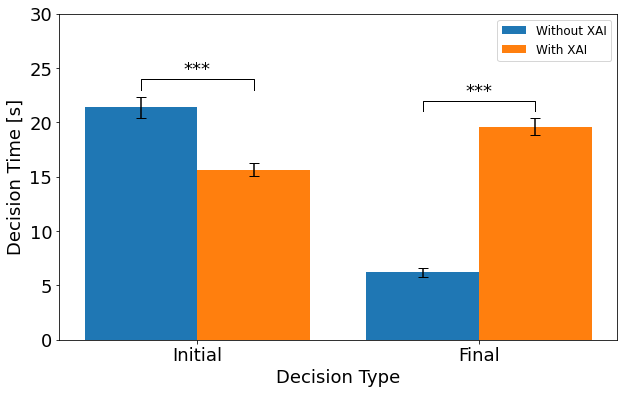

In [55]:
# obtain average human decision time and human-ai decision for XAI = 1 and XAI = 0 (from SPSS)
# global results first
# for each task, mean and SEM
import numpy as np
import pandas as pd

decision_data = pd.read_csv('decision_times.csv')

def mean(df, column):
    mean = df[column].mean()
    return mean
def sem(df, column):
    sem = df[column].std(ddof=1) / np.sqrt(len(df))
    return sem


results_xai = {
    "human_decision_time_mean_0": mean(decision_data[decision_data['XAI_value'] == 0], 'human_decision_time'),
    "human_decision_time_sem_0": sem(decision_data[decision_data['XAI_value'] == 0], 'human_decision_time'),
    "human_ai_decision_time_mean_0": mean(decision_data[decision_data['XAI_value'] == 0], 'human_ai_decision_time'),
    "human_ai_decision_time_sem_0": sem(decision_data[decision_data['XAI_value'] == 0], 'human_ai_decision_time'),
    "human_decision_time_mean_1": mean(decision_data[decision_data['XAI_value'] == 1], 'human_decision_time'),
    "human_decision_time_sem_1": sem(decision_data[decision_data['XAI_value'] == 1], 'human_decision_time'),
    "human_ai_decision_time_mean_1": mean(decision_data[decision_data['XAI_value'] == 1], 'human_ai_decision_time'),
    "human_ai_decision_time_sem_1": sem(decision_data[decision_data['XAI_value'] == 1], 'human_ai_decision_time')
}

# print(results_xai)
# save the results to a csv file
results_df = pd.DataFrame([results_xai])

results_df.to_csv('decision_times_global_results.csv', index=False)

import matplotlib.pyplot as plt

ai_decision_o = results_xai['human_ai_decision_time_mean_0']
ai_decision_ox = results_xai['human_ai_decision_time_mean_1']
ai_decision_o_sem = results_xai['human_ai_decision_time_sem_0']
ai_decision_ox_sem = results_xai['human_ai_decision_time_sem_1']

human_decision_o = results_xai['human_decision_time_mean_0']
human_decision_ox = results_xai['human_decision_time_mean_1']
human_decision_o_sem = results_xai['human_decision_time_sem_0']
human_decision_ox_sem = results_xai['human_decision_time_sem_1']

def add_significance(ax, x1, x2, y, h=0.03, significance='*', linewidth=1, color='k'):
    """
    Add a significance bar between two x positions on the given axis.

    Parameters:
    - x1, x2: The x coordinates of the two groups being compared.
    - y: The y coordinate (height) where the bar should be placed. altura
    - h: Height of the little 'bump' on the bar. width
    - significance: The string to place on the bar (e.g., '', '*', 'n.s.').
    - linewidth: The width of the line.
    - color: Color of the line and text.
    """
    ax.plot([x1, x1, x2, x2], [y, y+h, y+h, y], linewidth=linewidth, color=color)
    ax.text((x1+x2)*.5, y+h, significance, ha='center', va='bottom', color=color)



# Create a barplot
labels = ['Initial', 'Final']
positions = [0, 0.5]
x = [0, 0.5]
x1 = x[0] - 0.1
x2 = x[0] + 0.1
x3 = x[1] - 0.1
x4 = x[1] + 0.1

melted_elmo = pd.read_csv('data_melted_elmo_spss.csv')
human_time_o = melted_elmo[melted_elmo['XAI'] == False]['HTime']
human_time_ox = melted_elmo[melted_elmo['XAI'] == True]['HTime']
ai_time_o = melted_elmo[melted_elmo['XAI'] == False]['HAITime']
ai_time_ox = melted_elmo[melted_elmo['XAI'] == True]['HAITime']


avg_human_time_o = human_time_o.mean()
avg_human_time_ox = human_time_ox.mean()
avg_ai_time_o = ai_time_o.mean()
avg_ai_time_ox = ai_time_ox.mean()

sem_human_time_o = human_time_o.std(ddof=1) / np.sqrt(len(human_time_o))
sem_human_time_ox = human_time_ox.std(ddof=1) / np.sqrt(len(human_time_ox))
sem_ai_time_o = ai_time_o.std(ddof=1) / np.sqrt(len(ai_time_o))
sem_ai_time_ox = ai_time_ox.std(ddof=1) / np.sqrt(len(ai_time_ox))

print(avg_human_time_o, avg_human_time_ox, avg_ai_time_o, avg_ai_time_ox)
# bar plot with error bars, separate with colors
fig, ax = plt.subplots(figsize = (10, 6))



ax.bar(x1, avg_human_time_o, yerr=sem_human_time_o, width=0.2, color='tab:blue', linestyle = '', capsize=5)
ax.bar(x3, avg_ai_time_o, yerr=sem_ai_time_o, width=0.2, color='tab:blue', linestyle = '', capsize=5, label = 'Without XAI')
ax.bar(x2, avg_human_time_ox, yerr=sem_human_time_ox, width=0.2, color='tab:orange', linestyle = '', capsize=5, label = 'With XAI')
ax.bar(x4, avg_ai_time_ox, yerr=sem_ai_time_ox, width=0.2, color='tab:orange', linestyle = '', capsize=5)

add_significance(ax, x1 = -0.1, x2 = 0.1, y = 23, h = 1, significance = '***')
add_significance(ax, x1 = 0.4, x2 = 0.6, y = 21, h = 1, significance = '***')

# plt.bar(y_index, [human_decision_o, ai_decision_o], [human_decision_o_sem, ai_decision_o_sem], color='black', marker = 'o', markeredgecolor = 'black', markerfacecolor = 'white', ls = '-', capsize=5, capthick=1, ecolor='black')
# plt.bar(y_index, [human_decision_ox, ai_decision_ox], [human_decision_ox_sem, ai_decision_ox_sem], markeredgecolor = 'black', color='black', marker = 'o', ls = '--', capsize=5, capthick=1, ecolor='black')

# handles = [
#         plt.Line2D([], [], color='black', linestyle='-', label='XAI = False'),
#         plt.Line2D([], [], color='black', linestyle='--', label='XAI = True'),
#     ]
# plt.legend(handles=handles)

plt.rcParams.update({'font.size': 12})
plt.legend(loc = "upper right")
# font size
plt.rcParams.update({'font.size': 16})

plt.ylabel('Decision Time [s]')
plt.xlabel('Decision Type')
plt.ylim(0, 30)
plt.xticks(positions, labels)
plt.savefig('decision_times_barplot.pdf', dpi = 600, bbox_inches='tight')
plt.show()




### Decision Time Subtracted by rec_duration and XAI Durations in True XAI Condition, Decision Time Subtracted by rec_duration in False XAI

In [11]:
# obtain average human decision time and human-ai decision for XAI = 1 and XAI = 0 (from SPSS)
# global results first
# for each task, mean and SEM
import numpy as np
import pandas as pd

decision_data = pd.read_csv('mushroom_data/decision_times.csv')

def mean(df, column):
    mean = df[column].mean()
    return mean
def sem(df, column):
    sem = df[column].std(ddof=1) / np.sqrt(len(df))
    return sem

durations = pd.read_csv('gaze_data/XAI_durations.csv')

# Subtract the rec_duration and xai_durations from the human-ai decision time (with the same task) when XAI = 1
# Subtract the rec_duration from the human-ai decision time (with the same task) when XAI = 0
for i in range(len(decision_data)):
    row = decision_data.iloc[i]
    if row['XAI_value'] == 1:
        task = row['task']
        rec_duration = durations[durations['task'] == task]['rec_duration'].values[0]
        xai_duration = durations[durations['task'] == task]['xai_duration'].values[0]
        decision_data.at[i, 'subtracted_human_ai_decision_time'] = row['human_ai_decision_time'] - rec_duration - xai_duration
    else:
        task = row['task']
        rec_duration = durations[durations['task'] == task]['rec_duration'].values[0]
        decision_data.at[i, 'subtracted_human_ai_decision_time'] = row['human_ai_decision_time'] - rec_duration


decision_data.to_csv('mushroom_data/decision_times_subtracted.csv', index=False) 


results_xai = {
    "human_decision_time_mean_0": mean(decision_data[decision_data['XAI_value'] == 0], 'human_decision_time'),
    "human_decision_time_sem_0": sem(decision_data[decision_data['XAI_value'] == 0], 'human_decision_time'),
    "human_ai_decision_time_mean_0": mean(decision_data[decision_data['XAI_value'] == 0], 'subtracted_human_ai_decision_time'),
    "human_ai_decision_time_sem_0": sem(decision_data[decision_data['XAI_value'] == 0], 'subtracted_human_ai_decision_time'),
    "human_decision_time_mean_1": mean(decision_data[decision_data['XAI_value'] == 1], 'human_decision_time'),
    "human_decision_time_sem_1": sem(decision_data[decision_data['XAI_value'] == 1], 'human_decision_time'),
    "human_ai_decision_time_mean_1": mean(decision_data[decision_data['XAI_value'] == 1], 'subtracted_human_ai_decision_time'),
    "human_ai_decision_time_sem_1": sem(decision_data[decision_data['XAI_value'] == 1], 'subtracted_human_ai_decision_time')
}

print(results_xai)
# save the results to a csv file
results_df = pd.DataFrame([results_xai])

results_df.to_csv('mushroom_data/subtracted_decision_times_global_results.csv', index=False)



import matplotlib.pyplot as plt

ai_decision_o = results_xai['human_ai_decision_time_mean_0']
ai_decision_ox = results_xai['human_ai_decision_time_mean_1']
ai_decision_o_sem = results_xai['human_ai_decision_time_sem_0']
ai_decision_ox_sem = results_xai['human_ai_decision_time_sem_1']

human_decision_o = results_xai['human_decision_time_mean_0']
human_decision_ox = results_xai['human_decision_time_mean_1']
human_decision_o_sem = results_xai['human_decision_time_sem_0']
human_decision_ox_sem = results_xai['human_decision_time_sem_1']

positions = [0, 10]
labels = ['Human', 'Human-AI']
y_index = [0, 10]
    
plt.figure(figsize=(10, 6))
plt.errorbar(y_index, [human_decision_o, ai_decision_o], [human_decision_o_sem, ai_decision_o_sem], color='black', marker = 'o', markeredgecolor = 'black', markerfacecolor = 'white', ls = '-', capsize=5, capthick=1, ecolor='black')
plt.errorbar(y_index, [human_decision_ox, ai_decision_ox], [human_decision_ox_sem, ai_decision_ox_sem], markeredgecolor = 'black', color='black', marker = 'o', ls = '--', capsize=5, capthick=1, ecolor='black')

handles = [
        plt.Line2D([], [], color='black', linestyle='-', label='XAI = False'),
        plt.Line2D([], [], color='black', linestyle='--', label='XAI = True'),
    ]
plt.legend(handles=handles)

plt.ylabel('Decision Time [s]')
plt.xlabel('Decision Type')
plt.xticks(positions, labels)
# plt.title('Elmo Fixation Count')
plt.savefig('mushroom_results/decision_times_XAI_subtracted_boxplot.png', dpi = 1600, bbox_inches='tight')
plt.show()


FileNotFoundError: [Errno 2] No such file or directory: 'mushroom_data/decision_times.csv'

### Normalized by Human Decision Time


In [ ]:
# obtain average human decision time and human-ai decision for XAI = 1 and XAI = 0 (from SPSS)
# global results first
# for each task, mean and SEM
import numpy as np
import pandas as pd

decision_data = pd.read_csv('mushroom_data/decision_times.csv')

def mean(df, column):
    mean = df[column].mean()
    return mean
def sem(df, column):
    sem = df[column].std(ddof=1) / np.sqrt(len(df))
    return sem


results_xai = {
    "human_decision_time_mean_0": mean(decision_data[decision_data['XAI_value'] == 0], 'human_decision_time'),
    "human_decision_time_sem_0": sem(decision_data[decision_data['XAI_value'] == 0], 'human_decision_time'),
    "human_ai_decision_time_mean_0": mean(decision_data[decision_data['XAI_value'] == 0], 'human_ai_decision_time'),
    "human_ai_decision_time_sem_0": sem(decision_data[decision_data['XAI_value'] == 0], 'human_ai_decision_time'),
    "human_decision_time_mean_1": mean(decision_data[decision_data['XAI_value'] == 1], 'human_decision_time'),
    "human_decision_time_sem_1": sem(decision_data[decision_data['XAI_value'] == 1], 'human_decision_time'),
    "human_ai_decision_time_mean_1": mean(decision_data[decision_data['XAI_value'] == 1], 'human_ai_decision_time'),
    "human_ai_decision_time_sem_1": sem(decision_data[decision_data['XAI_value'] == 1], 'human_ai_decision_time')
}

print(results_xai)
# save the results to a csv file
results_df = pd.DataFrame([results_xai])

results_df.to_csv('mushroom_data/decision_times_global_results.csv', index=False)


import matplotlib.pyplot as plt

ai_decision_o = results_xai['human_ai_decision_time_mean_0']
ai_decision_ox = results_xai['human_ai_decision_time_mean_1']
ai_decision_o_sem = results_xai['human_ai_decision_time_sem_0']
ai_decision_ox_sem = results_xai['human_ai_decision_time_sem_1']

human_decision_o = results_xai['human_decision_time_mean_0']
human_decision_ox = results_xai['human_decision_time_mean_1']
human_decision_o_sem = results_xai['human_decision_time_sem_0']
human_decision_ox_sem = results_xai['human_decision_time_sem_1']

positions = [0, 10]
labels = ['False', 'True']
y_index = [0, 10]

# SEM of ratio X/Y = sqrt((SEM_X/X)**2 + (SEM_Y/Y)**2)/Y

sem_normalized_o = ai_decision_o*np.sqrt((human_decision_o_sem/human_decision_o)**2 + (ai_decision_o_sem/ai_decision_o)**2)/human_decision_o
sem_normalized_ox = ai_decision_ox*np.sqrt((human_decision_ox_sem/human_decision_ox)**2 + (ai_decision_ox_sem/ai_decision_ox)**2)/human_decision_ox

plt.figure(figsize=(10, 6))
plt.errorbar(y_index, [ai_decision_o/human_decision_o, ai_decision_ox/human_decision_ox], [sem_normalized_o, sem_normalized_ox], color='black', marker = 'o', markeredgecolor = 'black', markerfacecolor = 'white', ls = '-', capsize=5, capthick=1, ecolor='black')

plt.ylabel('Human-AI Decision Time / Human Decision Time')
plt.xlabel('XAI Model')
plt.xticks(positions, labels)
# plt.title('Elmo Fixation Count')
plt.savefig('mushroom_results/normalized_decision_times_boxplot.png', dpi = 1600, bbox_inches='tight')
plt.show()



### Normalized by mean and STD


In [ ]:
# obtain average human decision time and human-ai decision for XAI = 1 and XAI = 0 (from SPSS)
# global results first
# for each task, mean and SEM
import numpy as np
import pandas as pd

decision_data = pd.read_csv('mushroom_data/decision_times.csv')

def mean(df, column):
    mean = df[column].mean()
    return mean
def sem(df, column):
    sem = df[column].std(ddof=1) / np.sqrt(len(df))
    return sem
def std(df, column):
    std = df[column].std(ddof=1)
    return std

results_xai = {
    "human_decision_time_mean_0": mean(decision_data[decision_data['XAI_value'] == 0], 'human_decision_time'),
    "human_decision_time_sem_0": sem(decision_data[decision_data['XAI_value'] == 0], 'human_decision_time'),
    "human_decision_time_std_0": std(decision_data[decision_data['XAI_value'] == 0], 'human_decision_time'),
    "human_ai_decision_time_mean_0": mean(decision_data[decision_data['XAI_value'] == 0], 'human_ai_decision_time'),
    "human_ai_decision_time_sem_0": sem(decision_data[decision_data['XAI_value'] == 0], 'human_ai_decision_time'),
    "human_ai_decision_time_std_0": std(decision_data[decision_data['XAI_value'] == 0], 'human_ai_decision_time'),
    "human_decision_time_mean_1": mean(decision_data[decision_data['XAI_value'] == 1], 'human_decision_time'),
    "human_decision_time_sem_1": sem(decision_data[decision_data['XAI_value'] == 1], 'human_decision_time'),
    "human_decision_time_std_1": std(decision_data[decision_data['XAI_value'] == 1], 'human_decision_time'),
    "human_ai_decision_time_mean_1": mean(decision_data[decision_data['XAI_value'] == 1], 'human_ai_decision_time'),
    "human_ai_decision_time_sem_1": sem(decision_data[decision_data['XAI_value'] == 1], 'human_ai_decision_time'),
    "human_ai_decision_time_std_1": std(decision_data[decision_data['XAI_value'] == 1], 'human_ai_decision_time')
}
print(results_xai)
# save the results to a csv file
results_df = pd.DataFrame([results_xai])
results_df.to_csv('mushroom_data/decision_times_global_results.csv', index=False)

def normalize(df, column, mean, std):
    normalized = (df[column] - mean)/std
    return normalized

# for all users, normalize the decision times by the mean human decision time and std human decision time
normalized_results = decision_data.copy()
normalized_results['normalized_human_decision_time_o'] = normalize(decision_data[decision_data['XAI_value'] == 0], 'human_decision_time', np.array(results_xai['human_decision_time_mean_0']), np.array(results_xai['human_decision_time_std_0']))
normalized_results['normalized_human_decision_time_ox'] = normalize(decision_data[decision_data['XAI_value'] == 1], 'human_decision_time', np.array(results_xai['human_decision_time_mean_1']), np.array(results_xai['human_decision_time_std_1']))
normalized_results['normalized_human_ai_decision_time_o'] = normalize(decision_data[decision_data['XAI_value'] == 0], 'human_ai_decision_time', np.array(results_xai['human_decision_time_mean_0']), np.array(results_xai['human_decision_time_std_0']))
normalized_results['normalized_human_ai_decision_time_ox'] = normalize(decision_data[decision_data['XAI_value'] == 1], 'human_ai_decision_time', np.array(results_xai['human_decision_time_mean_1']), np.array(results_xai['human_decision_time_std_1']))

# convert dict to DataFrame
normalized_results = pd.DataFrame(normalized_results)
normalized_results.to_csv('mushroom_data/decision_times_normalized.csv', index=False)

import matplotlib.pyplot as plt

ai_decision_o = results_xai['human_ai_decision_time_mean_0']
ai_decision_ox = results_xai['human_ai_decision_time_mean_1']
ai_decision_o_sem = results_xai['human_ai_decision_time_sem_0']
ai_decision_ox_sem = results_xai['human_ai_decision_time_sem_1']
ai_decision_o_std = results_xai['human_ai_decision_time_std_0']
ai_decision_ox_std = results_xai['human_ai_decision_time_std_1']

human_decision_o = results_xai['human_decision_time_mean_0']
human_decision_ox = results_xai['human_decision_time_mean_1']
human_decision_o_sem = results_xai['human_decision_time_sem_0']
human_decision_ox_sem = results_xai['human_decision_time_sem_1']
human_decision_o_std = results_xai['human_decision_time_std_0']
human_decision_ox_std = results_xai['human_decision_time_std_1']

positions = [0, 10]
labels = ['False', 'True']
y_index = [0, 10]

normalized_mean_ai_decision_o = mean(normalized_results, 'normalized_human_ai_decision_time_o')
normalized_mean_ai_decision_ox = mean(normalized_results, 'normalized_human_ai_decision_time_ox')
normalized_sem_ai_decision_o = sem(normalized_results, 'normalized_human_ai_decision_time_o')
normalized_sem_ai_decision_ox = sem(normalized_results, 'normalized_human_ai_decision_time_ox')

normalized_mean_human_decision_o = mean(normalized_results, 'normalized_human_decision_time_o')
normalized_mean_human_decision_ox = mean(normalized_results, 'normalized_human_decision_time_ox')
normalized_sem_human_decision_o = sem(normalized_results, 'normalized_human_decision_time_o')
normalized_sem_human_decision_ox = sem(normalized_results, 'normalized_human_decision_time_ox')


plt.figure(figsize=(10, 6))
plt.errorbar(y_index, [normalized_mean_human_decision_o, normalized_mean_human_decision_ox],[normalized_sem_human_decision_o, normalized_sem_human_decision_ox] , color='black', marker = 'o', markeredgecolor = 'black', markerfacecolor = 'white', ls = '-', capsize=5, capthick=1, ecolor='black')
plt.ylabel('Normalized Human Decision Time')
plt.xlabel('XAI Model')
plt.xticks(positions, labels)
plt.savefig('mushroom_results/mean_std_human_decision_times_boxplot.png', dpi = 1600, bbox_inches='tight')

plt.figure(figsize=(10, 6))
plt.errorbar(y_index, [normalized_mean_ai_decision_o, normalized_mean_ai_decision_ox],[normalized_sem_ai_decision_o, normalized_sem_ai_decision_ox] , color='black', marker = 'o', markeredgecolor = 'black', markerfacecolor = 'white', ls = '-', capsize=5, capthick=1, ecolor='black')
plt.ylabel('Normalized Human-AI Decision Time')
plt.xlabel('XAI Model')
plt.xticks(positions, labels)
# plt.title('Elmo Fixation Count')
plt.savefig('mushroom_results/mean_std_ai_decision_times_boxplot.png', dpi = 1600, bbox_inches='tight')


plt.show()




### Time plot of XAI = True and False from Task 1- 15


0     13
1     16
2     10
3     11
4     15
5     13
6     13
7     11
8     18
9     15
10    12
11    17
12    12
13    13
14     8
Name: xai_duration, dtype: int64


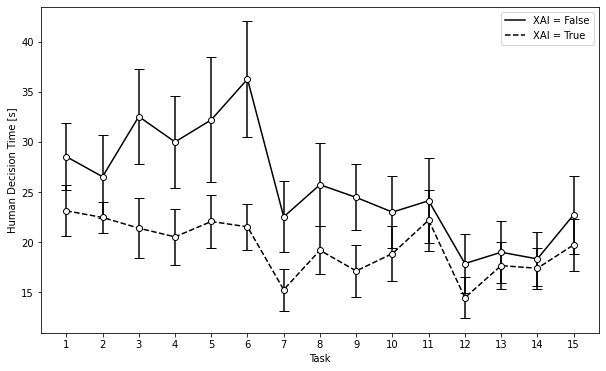

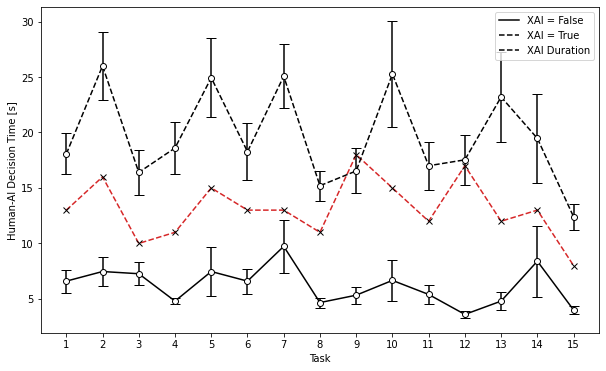

In [2]:
import numpy as np
import pandas as pd

decision_data = pd.read_csv('decision_times.csv')

def mean(df, column):
    mean = df[column].mean()
    return mean
def sem(df, column):
    sem = df[column].std(ddof=1) / np.sqrt(len(df))
    return sem

# obtain all mean and SEMs for each task 1-15 
results_xai = {}

for i in range(1, 16):
    results_xai[f"task_{i}_human_decision_time_mean_0"] = mean(decision_data[(decision_data['XAI_value'] == 0) & (decision_data['task'] == i)], 'human_decision_time')
    results_xai[f"task_{i}_human_decision_time_sem_0"] = sem(decision_data[(decision_data['XAI_value'] == 0) & (decision_data['task'] == i)], 'human_decision_time')
    results_xai[f"task_{i}_human_ai_decision_time_mean_0"] = mean(decision_data[(decision_data['XAI_value'] == 0) & (decision_data['task'] == i)], 'human_ai_decision_time')
    results_xai[f"task_{i}_human_ai_decision_time_sem_0"] = sem(decision_data[(decision_data['XAI_value'] == 0) & (decision_data['task'] == i)], 'human_ai_decision_time')
    results_xai[f"task_{i}_human_decision_time_mean_1"] = mean(decision_data[(decision_data['XAI_value'] == 1) & (decision_data['task'] == i)], 'human_decision_time')
    results_xai[f"task_{i}_human_decision_time_sem_1"] = sem(decision_data[(decision_data['XAI_value'] == 1) & (decision_data['task'] == i)], 'human_decision_time')
    results_xai[f"task_{i}_human_ai_decision_time_mean_1"] = mean(decision_data[(decision_data['XAI_value'] == 1) & (decision_data['task'] == i)], 'human_ai_decision_time')
    results_xai[f"task_{i}_human_ai_decision_time_sem_1"] = sem(decision_data[(decision_data['XAI_value'] == 1) & (decision_data['task'] == i)], 'human_ai_decision_time')

# save the results to a csv file
results_df = pd.DataFrame([results_xai])

results_df.to_csv('decision_times_task_results.csv', index=False)

import matplotlib.pyplot as plt

ai_decision_o = [results_xai[f'task_{i}_human_ai_decision_time_mean_0'] for i in range(1, 16)]
ai_decision_ox = [results_xai[f'task_{i}_human_ai_decision_time_mean_1'] for i in range(1, 16)]
ai_decision_o_sem = [results_xai[f'task_{i}_human_ai_decision_time_sem_0'] for i in range(1, 16)]
ai_decision_ox_sem = [results_xai[f'task_{i}_human_ai_decision_time_sem_1'] for i in range(1, 16)]

human_decision_o = [results_xai[f'task_{i}_human_decision_time_mean_0'] for i in range(1, 16)]
human_decision_ox = [results_xai[f'task_{i}_human_decision_time_mean_1'] for i in range(1, 16)]
human_decision_o_sem = [results_xai[f'task_{i}_human_decision_time_sem_0'] for i in range(1, 16)]
human_decision_ox_sem = [results_xai[f'task_{i}_human_decision_time_sem_1'] for i in range(1, 16)]

positions = range(1, 16)
labels = [i for i in range(1, 16)]
y_index = range(1, 16)

# boxplot
plt.figure(figsize=(10, 6))
plt.errorbar(y_index, human_decision_o, human_decision_o_sem, color='black', marker = 'o', markeredgecolor = 'black', markerfacecolor = 'white', ls = '-', capsize=5, capthick=1, ecolor='black')
plt.errorbar(y_index, human_decision_ox, human_decision_ox_sem, color='black', marker = 'o', markeredgecolor = 'black', markerfacecolor = 'white', ls = '--', capsize=5, capthick=1, ecolor='black')
plt.ylabel('Human Decision Time [s]')
plt.xlabel('Task')
plt.xticks(positions, labels)
handles = [
        plt.Line2D([], [], color='black', linestyle='-', label='XAI = False'),
        plt.Line2D([], [], color='black', linestyle='--', label='XAI = True'),
    ]
plt.legend(handles=handles)
plt.savefig('human_decision_times_task_boxplot.png', dpi = 1600, bbox_inches='tight')

plt.figure(figsize=(10, 6))
xai_durations = pd.read_csv('XAI_durations.csv')
xai_durations = xai_durations['xai_duration']
print(xai_durations)
plt.errorbar(y_index, ai_decision_o, ai_decision_o_sem, color='black', marker = 'o', markeredgecolor = 'black', markerfacecolor = 'white', ls = '-', capsize=5, capthick=1, ecolor='black')
plt.errorbar(y_index, ai_decision_ox, ai_decision_ox_sem, color='black', marker = 'o', markeredgecolor = 'black', markerfacecolor = 'white', ls = '--', capsize=5, capthick=1, ecolor='black')
plt.ylabel('Human-AI Decision Time [s]')
plt.xlabel('Task')
plt.xticks(positions, labels)

plt.plot(y_index, xai_durations, color='tab:red', markeredgecolor = 'black', markerfacecolor = 'white', ls = '--', marker = 'x')

handles = [
        plt.Line2D([], [], color='black', linestyle='-', label='XAI = False'),
        plt.Line2D([], [], color='black', linestyle='--', label='XAI = True'),
        plt.Line2D([], [], color='black', linestyle='--', label='XAI Duration'),
    ]

plt.legend(handles=handles)
plt.savefig('human_ai_decision_times_task_boxplot.png', dpi = 1600, bbox_inches='tight')
plt.show()










### Human and Human-AI Decision Time by Trust Phases

20.8
{'early_build_human_decision_time_mean_0': 29.96, 'early_build_human_decision_time_sem_0': 2.0603017359705453, 'early_build_human_ai_decision_time_mean_0': 6.72, 'early_build_human_ai_decision_time_sem_0': 0.5923110943013244, 'early_build_human_decision_time_mean_1': 21.92, 'early_build_human_decision_time_sem_1': 1.114322805705472, 'early_build_human_ai_decision_time_mean_1': 20.8, 'early_build_human_ai_decision_time_sem_1': 1.239005704238336, 'early_recovery_human_decision_time_mean_0': 26.4, 'early_recovery_human_decision_time_sem_0': 1.9006874052859435, 'early_recovery_human_ai_decision_time_mean_0': 6.6, 'early_recovery_human_ai_decision_time_sem_0': 0.6818099917608019, 'early_recovery_human_decision_time_mean_1': 18.4, 'early_recovery_human_decision_time_sem_1': 1.0813738342355845, 'early_recovery_human_ai_decision_time_mean_1': 20.066666666666666, 'early_recovery_human_ai_decision_time_sem_1': 1.3748491590753547, 'late_recovery_human_decision_time_mean_0': 20.33333333333333

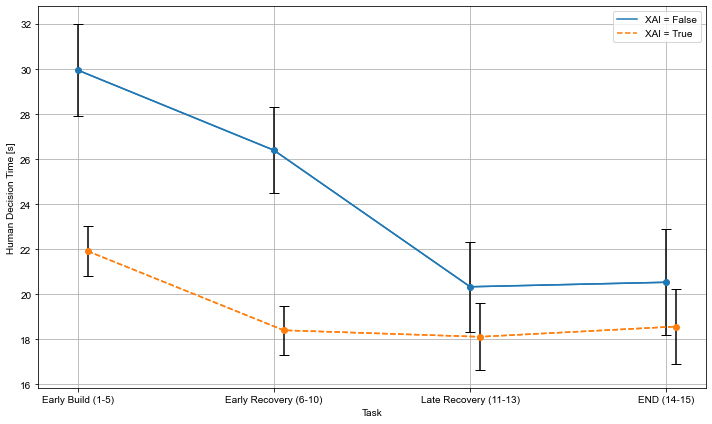

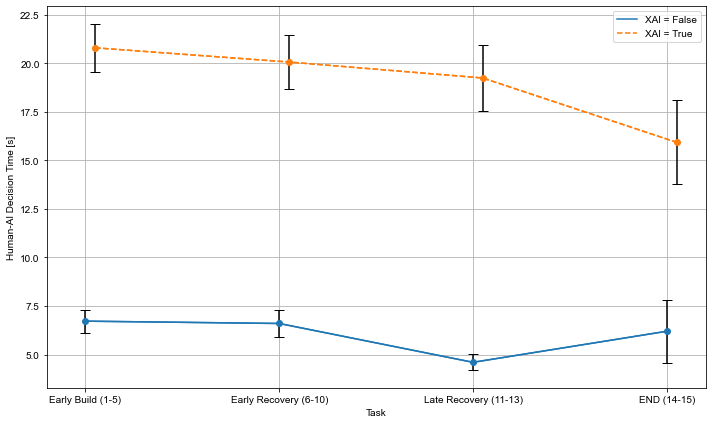

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
decision_data = pd.read_csv('mushroom_data/decision_times.csv')
plt.rcParams['font.family'] = 'sans-serif'  # Set global font to sans-serif
plt.rcParams['font.sans-serif'] = 'Arial'  # Specify the font name explicitly

def mean(df, column):
    mean = df[column].mean()
    return mean
def sem(df, column):
    sem = df[column].std(ddof=1) / np.sqrt(len(df))
    return sem

def get_XAI(idd):
    if '1' in idd:
        return 1
    else:
        return 0

# obtain all mean and SEMs for each trust phase 
results_xai = {}

early_build = [1, 2, 3, 4, 5]
early_recovery = [6, 7, 8, 9, 10]
late_recovery = [11, 12, 13]
end = [14, 15]

results_xai = {
    "early_build_human_decision_time_mean_0": mean(decision_data[(decision_data['XAI_value'] == 0) & (decision_data['task'].isin(early_build))], 'human_decision_time'),
    "early_build_human_decision_time_sem_0": sem(decision_data[(decision_data['XAI_value'] == 0) & (decision_data['task'].isin(early_build))], 'human_decision_time'),
    "early_build_human_ai_decision_time_mean_0": mean(decision_data[(decision_data['XAI_value'] == 0) & (decision_data['task'].isin(early_build))], 'human_ai_decision_time'),
    "early_build_human_ai_decision_time_sem_0": sem(decision_data[(decision_data['XAI_value'] == 0) & (decision_data['task'].isin(early_build))], 'human_ai_decision_time'),
    "early_build_human_decision_time_mean_1": mean(decision_data[(decision_data['XAI_value'] == 1) & (decision_data['task'].isin(early_build))], 'human_decision_time'),
    "early_build_human_decision_time_sem_1": sem(decision_data[(decision_data['XAI_value'] == 1) & (decision_data['task'].isin(early_build))], 'human_decision_time'),
    "early_build_human_ai_decision_time_mean_1": mean(decision_data[(decision_data['XAI_value'] == 1) & (decision_data['task'].isin(early_build))], 'human_ai_decision_time'),
    "early_build_human_ai_decision_time_sem_1": sem(decision_data[(decision_data['XAI_value'] == 1) & (decision_data['task'].isin(early_build))], 'human_ai_decision_time'),
    "early_recovery_human_decision_time_mean_0": mean(decision_data[(decision_data['XAI_value'] == 0) & (decision_data['task'].isin(early_recovery))], 'human_decision_time'),
    "early_recovery_human_decision_time_sem_0": sem(decision_data[(decision_data['XAI_value'] == 0) & (decision_data['task'].isin(early_recovery))], 'human_decision_time'),
    "early_recovery_human_ai_decision_time_mean_0": mean(decision_data[(decision_data['XAI_value'] == 0) & (decision_data['task'].isin(early_recovery))], 'human_ai_decision_time'),
    "early_recovery_human_ai_decision_time_sem_0": sem(decision_data[(decision_data['XAI_value'] == 0) & (decision_data['task'].isin(early_recovery))], 'human_ai_decision_time'),
    "early_recovery_human_decision_time_mean_1": mean(decision_data[(decision_data['XAI_value'] == 1) & (decision_data['task'].isin(early_recovery))], 'human_decision_time'),
    "early_recovery_human_decision_time_sem_1": sem(decision_data[(decision_data['XAI_value'] == 1) & (decision_data['task'].isin(early_recovery))], 'human_decision_time'),
    "early_recovery_human_ai_decision_time_mean_1": mean(decision_data[(decision_data['XAI_value'] == 1) & (decision_data['task'].isin(early_recovery))], 'human_ai_decision_time'),
    "early_recovery_human_ai_decision_time_sem_1": sem(decision_data[(decision_data['XAI_value'] == 1) & (decision_data['task'].isin(early_recovery))], 'human_ai_decision_time'),
    "late_recovery_human_decision_time_mean_0": mean(decision_data[(decision_data['XAI_value'] == 0) & (decision_data['task'].isin(late_recovery))], 'human_decision_time'),
    "late_recovery_human_decision_time_sem_0": sem(decision_data[(decision_data['XAI_value'] == 0) & (decision_data['task'].isin(late_recovery))], 'human_decision_time'),
    "late_recovery_human_ai_decision_time_mean_0": mean(decision_data[(decision_data['XAI_value'] == 0) & (decision_data['task'].isin(late_recovery))], 'human_ai_decision_time'),
    "late_recovery_human_ai_decision_time_sem_0": sem(decision_data[(decision_data['XAI_value'] == 0) & (decision_data['task'].isin(late_recovery))], 'human_ai_decision_time'),
    "late_recovery_human_decision_time_mean_1": mean(decision_data[(decision_data['XAI_value'] == 1) & (decision_data['task'].isin(late_recovery))], 'human_decision_time'),
    "late_recovery_human_decision_time_sem_1": sem(decision_data[(decision_data['XAI_value'] == 1) & (decision_data['task'].isin(late_recovery))], 'human_decision_time'),
    "late_recovery_human_ai_decision_time_mean_1": mean(decision_data[(decision_data['XAI_value'] == 1) & (decision_data['task'].isin(late_recovery))], 'human_ai_decision_time'),
    "late_recovery_human_ai_decision_time_sem_1": sem(decision_data[(decision_data['XAI_value'] == 1) & (decision_data['task'].isin(late_recovery))], 'human_ai_decision_time'),
    "end_human_decision_time_mean_0": mean(decision_data[(decision_data['XAI_value'] == 0) & (decision_data['task'].isin(end))], 'human_decision_time'),
    "end_human_decision_time_sem_0": sem(decision_data[(decision_data['XAI_value'] == 0) & (decision_data['task'].isin(end))], 'human_decision_time'),
    "end_human_ai_decision_time_mean_0": mean(decision_data[(decision_data['XAI_value'] == 0) & (decision_data['task'].isin(end))], 'human_ai_decision_time'),
    "end_human_ai_decision_time_sem_0": sem(decision_data[(decision_data['XAI_value'] == 0) & (decision_data['task'].isin(end))], 'human_ai_decision_time'),
    "end_human_decision_time_mean_1": mean(decision_data[(decision_data['XAI_value'] == 1) & (decision_data['task'].isin(end))], 'human_decision_time'),
    "end_human_decision_time_sem_1": sem(decision_data[(decision_data['XAI_value'] == 1) & (decision_data['task'].isin(end))], 'human_decision_time'),
    "end_human_ai_decision_time_mean_1": mean(decision_data[(decision_data['XAI_value'] == 1) & (decision_data['task'].isin(end))], 'human_ai_decision_time'),
    "end_human_ai_decision_time_sem_1": sem(decision_data[(decision_data['XAI_value'] == 1) & (decision_data['task'].isin(end))], 'human_ai_decision_time')
}

# save the results to a csv file
# also save XAI_value
results_df = pd.DataFrame([results_xai])
results_df.to_csv('mushroom_data/decision_times_trust_phases_results.csv', index=False)

print(results_xai['early_build_human_ai_decision_time_mean_1'])
print(results_xai)

ai_decision_o = [results_xai['early_build_human_ai_decision_time_mean_0'],\
                results_xai['early_recovery_human_ai_decision_time_mean_0'],\
                results_xai['late_recovery_human_ai_decision_time_mean_0'],\
                results_xai['end_human_ai_decision_time_mean_0']]

ai_decision_ox = [results_xai['early_build_human_ai_decision_time_mean_1'], \
                results_xai['early_recovery_human_ai_decision_time_mean_1'],\
                results_xai['late_recovery_human_ai_decision_time_mean_1'], \
                results_xai['end_human_ai_decision_time_mean_1']]

ai_decision_o_sem = [results_xai['early_build_human_ai_decision_time_sem_0'],\
                results_xai['early_recovery_human_ai_decision_time_sem_0'],\
                results_xai['late_recovery_human_ai_decision_time_sem_0'], \
                results_xai['end_human_ai_decision_time_sem_0']]

ai_decision_ox_sem = [results_xai['early_build_human_ai_decision_time_sem_1'],\
                results_xai['early_recovery_human_ai_decision_time_sem_1'],\
                results_xai['late_recovery_human_ai_decision_time_sem_1'], \
                results_xai['end_human_ai_decision_time_sem_1']]

human_decision_o = [results_xai['early_build_human_decision_time_mean_0'],\
                results_xai['early_recovery_human_decision_time_mean_0'],\
                results_xai['late_recovery_human_decision_time_mean_0'], \
                results_xai['end_human_decision_time_mean_0']]
human_decision_ox = [results_xai['early_build_human_decision_time_mean_1'],\
                results_xai['early_recovery_human_decision_time_mean_1'],\
                results_xai['late_recovery_human_decision_time_mean_1'], \
                results_xai['end_human_decision_time_mean_1']]
human_decision_o_sem = [results_xai['early_build_human_decision_time_sem_0'],\
                results_xai['early_recovery_human_decision_time_sem_0'],\
                results_xai['late_recovery_human_decision_time_sem_0'], \
                results_xai['end_human_decision_time_sem_0']]

human_decision_ox_sem = [results_xai['early_build_human_decision_time_sem_1'],\
                results_xai['early_recovery_human_decision_time_sem_1'],\
                results_xai['late_recovery_human_decision_time_sem_1'], \
                results_xai['end_human_decision_time_sem_1']]
# Create the plot
intro = -2
tutorial = 0
test = [5, 10, 15, 20]
# add together intro,tutorial and test
task = np.concatenate((np.array([intro, tutorial]), test))
positions = [5, 10, 15, 20]
labels = ['Early Build (1-5)', 'Early Recovery (6-10)', 'Late Recovery (11-13)', 'END (14-15)']
task_ox = [-2, 0, 5.25, 10.25, 15.25, 20.25] # so they don't overlap


# boxplot
plt.figure(figsize=(10, 6))

plt.errorbar(task[2:], human_decision_o, human_decision_o_sem, color='tab:blue',  ls='-', marker='o', capsize=5, capthick=1, ecolor='black')
plt.errorbar(task_ox[2:], human_decision_ox, human_decision_ox_sem, color='tab:orange', marker = 'o', ls = '--', capsize=5, capthick=1, ecolor='black')
plt.plot(task[2:], human_decision_o, color='tab:blue', linestyle = '-')
plt.plot(task_ox[2:], human_decision_ox, color='tab:orange', linestyle = '--')
# Add legend for markers "s" and "P" only once
handles = [
        plt.Line2D([], [], color='tab:blue', linestyle='-', label='XAI = False'),
        plt.Line2D([], [], color='tab:orange', linestyle='--', label='XAI = True'),
    ]
plt.legend(handles=handles)
plt.xlim(4, 21)
# Set the x-axis ticks and labels
plt.xticks(positions, labels)
# Add labels and title
plt.xlabel('Task')
plt.ylabel('Human Decision Time [s]')
plt.grid(True)
# Show the plot
plt.tight_layout()
plt.savefig('mushroom_results/human_decision_time_by_trust_phases.png', dpi=600, bbox_inches='tight')

plt.figure(figsize=(10, 6))
plt.errorbar(task[2:], ai_decision_o, ai_decision_o_sem, color='tab:blue',  ls='-', marker='o', capsize=5, capthick=1, ecolor='black')
plt.errorbar(task_ox[2:], ai_decision_ox, ai_decision_ox_sem, color='tab:orange', marker = 'o', ls = '--', capsize=5, capthick=1, ecolor='black')
plt.plot(task[2:], ai_decision_o, color='tab:blue', linestyle = '-')
plt.plot(task_ox[2:], ai_decision_ox, color='tab:orange', linestyle = '--')
# Add legend for markers "s" and "P" only once
handles = [
        plt.Line2D([], [], color='tab:blue', linestyle='-', label='XAI = False'),
        plt.Line2D([], [], color='tab:orange', linestyle='--', label='XAI = True'),
    ]
plt.legend(handles=handles)
plt.xlim(4, 21)
# Set the x-axis ticks and labels
plt.xticks(positions, labels)
# Add labels and title
plt.xlabel('Task')
plt.ylabel('Human-AI Decision Time [s]')
plt.grid(True)
plt.tight_layout()
plt.savefig('mushroom_results/human_ai_decision_time_by_trust_phases.png', dpi=600, bbox_inches='tight')
plt.show()




### Decision Time By Trust Phase


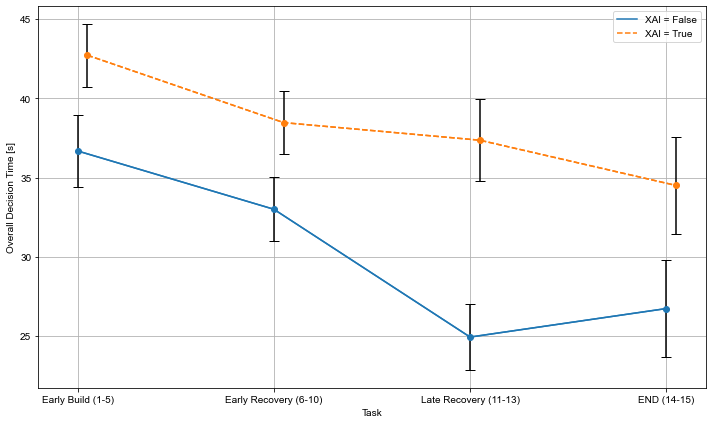

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
decision_data = pd.read_csv('mushroom_data/decision_times.csv')

decision_data['global_decision_time'] = decision_data['human_decision_time'] + decision_data['human_ai_decision_time']

plt.rcParams['font.family'] = 'sans-serif'  # Set global font to sans-serif
plt.rcParams['font.sans-serif'] = 'Arial'  # Specify the font name explicitly

def mean(df, column):
    mean = df[column].mean()
    return mean
def sem(df, column):
    sem = df[column].std(ddof=1) / np.sqrt(len(df))
    return sem

def get_XAI(idd):
    if '1' in idd:
        return 1
    else:
        return 0

# obtain all mean and SEMs for each trust phase 
results_xai = {}

early_build = [1, 2, 3, 4, 5]
early_recovery = [6, 7, 8, 9, 10]
late_recovery = [11, 12, 13]
end = [14, 15]

results_xai = {
    "early_build_decision_time_mean_0": mean(decision_data[(decision_data['XAI_value'] == 0) & (decision_data['task'].isin(early_build))], 'global_decision_time'),
    "early_build_decision_time_sem_0": sem(decision_data[(decision_data['XAI_value'] == 0) & (decision_data['task'].isin(early_build))], 'global_decision_time'),
    "early_build_decision_time_mean_1": mean(decision_data[(decision_data['XAI_value'] == 1) & (decision_data['task'].isin(early_build))], 'global_decision_time'),
    "early_build_decision_time_sem_1": sem(decision_data[(decision_data['XAI_value'] == 1) & (decision_data['task'].isin(early_build))], 'global_decision_time'),
    "early_recovery_decision_time_mean_0": mean(decision_data[(decision_data['XAI_value'] == 0) & (decision_data['task'].isin(early_recovery))], 'global_decision_time'),
    "early_recovery_decision_time_sem_0": sem(decision_data[(decision_data['XAI_value'] == 0) & (decision_data['task'].isin(early_recovery))], 'global_decision_time'),
    "early_recovery_decision_time_mean_1": mean(decision_data[(decision_data['XAI_value'] == 1) & (decision_data['task'].isin(early_recovery))], 'global_decision_time'),
    "early_recovery_decision_time_sem_1": sem(decision_data[(decision_data['XAI_value'] == 1) & (decision_data['task'].isin(early_recovery))], 'global_decision_time'),
    "late_recovery_decision_time_mean_0": mean(decision_data[(decision_data['XAI_value'] == 0) & (decision_data['task'].isin(late_recovery))], 'global_decision_time'),
    "late_recovery_decision_time_sem_0": sem(decision_data[(decision_data['XAI_value'] == 0) & (decision_data['task'].isin(late_recovery))], 'global_decision_time'),
    "late_recovery_decision_time_mean_1": mean(decision_data[(decision_data['XAI_value'] == 1) & (decision_data['task'].isin(late_recovery))], 'global_decision_time'),
    "late_recovery_decision_time_sem_1": sem(decision_data[(decision_data['XAI_value'] == 1) & (decision_data['task'].isin(late_recovery))], 'global_decision_time'),
    "end_decision_time_mean_0": mean(decision_data[(decision_data['XAI_value'] == 0) & (decision_data['task'].isin(end))], 'global_decision_time'),
    "end_decision_time_sem_0": sem(decision_data[(decision_data['XAI_value'] == 0) & (decision_data['task'].isin(end))], 'global_decision_time'),
    "end_decision_time_mean_1": mean(decision_data[(decision_data['XAI_value'] == 1) & (decision_data['task'].isin(end))], 'global_decision_time'),
    "end_decision_time_sem_1": sem(decision_data[(decision_data['XAI_value'] == 1) & (decision_data['task'].isin(end))], 'global_decision_time')
}

# save the results to a csv file
# also save XAI_value
results_df = pd.DataFrame([results_xai])
results_df.to_csv('mushroom_data/global_decision_times_trust_phases_results.csv', index=False)


global_decision_o = [results_xai['early_build_decision_time_mean_0'],\
                results_xai['early_recovery_decision_time_mean_0'],\
                results_xai['late_recovery_decision_time_mean_0'],\
                results_xai['end_decision_time_mean_0']]

global_decision_ox = [results_xai['early_build_decision_time_mean_1'], \
                results_xai['early_recovery_decision_time_mean_1'],\
                results_xai['late_recovery_decision_time_mean_1'], \
                results_xai['end_decision_time_mean_1']]
global_decision_o_sem = [results_xai['early_build_decision_time_sem_0'],\
                results_xai['early_recovery_decision_time_sem_0'],\
                results_xai['late_recovery_decision_time_sem_0'], \
                results_xai['end_decision_time_sem_0']]
global_decision_ox_sem = [results_xai['early_build_decision_time_sem_1'],\
                results_xai['early_recovery_decision_time_sem_1'],\
                results_xai['late_recovery_decision_time_sem_1'], \
                results_xai['end_decision_time_sem_1']]

# Create the plot
intro = -2
tutorial = 0
test = [5, 10, 15, 20]
# add together intro,tutorial and test
task = np.concatenate((np.array([intro, tutorial]), test))
positions = [5, 10, 15, 20]
labels = ['Early Build (1-5)', 'Early Recovery (6-10)', 'Late Recovery (11-13)', 'END (14-15)']
task_ox = [-2, 0, 5.25, 10.25, 15.25, 20.25] # so they don't overlap


# boxplot
plt.figure(figsize=(10, 6))

plt.errorbar(task[2:], global_decision_o, global_decision_o_sem, color='tab:blue',  ls='-', marker='o', capsize=5, capthick=1, ecolor='black')
plt.errorbar(task_ox[2:], global_decision_ox, global_decision_ox_sem, color='tab:orange', marker = 'o', ls = '--', capsize=5, capthick=1, ecolor='black')
plt.plot(task[2:], global_decision_o, color='tab:blue', linestyle = '-')
plt.plot(task_ox[2:], global_decision_ox, color='tab:orange', linestyle = '--')
# Add legend for markers "s" and "P" only once
handles = [
        plt.Line2D([], [], color='tab:blue', linestyle='-', label='XAI = False'),
        plt.Line2D([], [], color='tab:orange', linestyle='--', label='XAI = True'),
    ]
plt.legend(handles=handles)
plt.xlim(4, 21)
# Set the x-axis ticks and labels
plt.xticks(positions, labels)
# Add labels and title
plt.xlabel('Task')
plt.ylabel('Overall Decision Time [s]')
plt.grid(True)
# Show the plot
plt.tight_layout()
plt.savefig('mushroom_results/global_decision_time_by_trust_phases.png', dpi=600, bbox_inches='tight')


### Normalized Time Plot of Human Decision Time IN XAI cONDITIONS

Normalized XAI Durations:  [0.57612763 0.70908017 0.4431751  0.48749261 0.66476266 0.57612763
 0.57612763 0.48749261 0.79771519 0.66476266 0.53181012 0.75339768
 0.53181012 0.57612763 0.35454008]
AI-Decision Normalized:  [0.25790205 0.29176797 0.28395276 0.18756513 0.29176797 0.25790205
 0.3803404  0.18235498 0.2084057  0.26050712 0.21101077 0.14067385
 0.18756513 0.32823897 0.15630427]
AI-Decision Normalized OX:  [0.92470428 1.33075523 0.83939945 0.95200182 1.27616015 0.93494086
 1.28298453 0.77797998 0.84622384 1.29322111 0.87010919 0.89740673
 1.18744313 0.99636033 0.63466788]


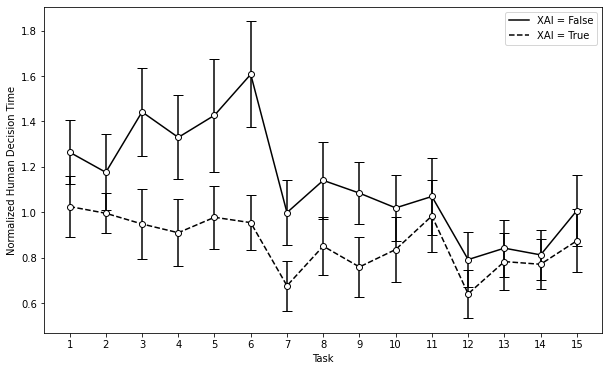

In [1]:
import numpy as np
import pandas as pd

decision_data = pd.read_csv('mushroom_data/decision_times.csv')

def mean(df, column):
    mean = df[column].mean()
    return mean
def sem(df, column):
    sem = df[column].std(ddof=1) / np.sqrt(len(df))
    return sem

# obtain all mean and SEMs for each task 1-15 
results_xai = {}

for i in range(1, 16):
    results_xai[f"task_{i}_human_decision_time_mean_0"] = mean(decision_data[(decision_data['XAI_value'] == 0) & (decision_data['task'] == i)], 'human_decision_time')
    results_xai[f"task_{i}_human_decision_time_sem_0"] = sem(decision_data[(decision_data['XAI_value'] == 0) & (decision_data['task'] == i)], 'human_decision_time')
    results_xai[f"task_{i}_human_ai_decision_time_mean_0"] = mean(decision_data[(decision_data['XAI_value'] == 0) & (decision_data['task'] == i)], 'human_ai_decision_time')
    results_xai[f"task_{i}_human_ai_decision_time_sem_0"] = sem(decision_data[(decision_data['XAI_value'] == 0) & (decision_data['task'] == i)], 'human_ai_decision_time')
    results_xai[f"task_{i}_human_decision_time_mean_1"] = mean(decision_data[(decision_data['XAI_value'] == 1) & (decision_data['task'] == i)], 'human_decision_time')
    results_xai[f"task_{i}_human_decision_time_sem_1"] = sem(decision_data[(decision_data['XAI_value'] == 1) & (decision_data['task'] == i)], 'human_decision_time')
    results_xai[f"task_{i}_human_ai_decision_time_mean_1"] = mean(decision_data[(decision_data['XAI_value'] == 1) & (decision_data['task'] == i)], 'human_ai_decision_time')
    results_xai[f"task_{i}_human_ai_decision_time_sem_1"] = sem(decision_data[(decision_data['XAI_value'] == 1) & (decision_data['task'] == i)], 'human_ai_decision_time')

# save the results to a csv file
results_df = pd.DataFrame([results_xai])

results_df.to_csv('mushroom_data/decision_times_task_results.csv', index=False)

import matplotlib.pyplot as plt

ai_decision_o = [results_xai[f'task_{i}_human_ai_decision_time_mean_0'] for i in range(1, 16)]
ai_decision_ox = [results_xai[f'task_{i}_human_ai_decision_time_mean_1'] for i in range(1, 16)]
ai_decision_o_sem = [results_xai[f'task_{i}_human_ai_decision_time_sem_0'] for i in range(1, 16)]
ai_decision_ox_sem = [results_xai[f'task_{i}_human_ai_decision_time_sem_1'] for i in range(1, 16)]

human_decision_o = [results_xai[f'task_{i}_human_decision_time_mean_0'] for i in range(1, 16)]
human_decision_ox = [results_xai[f'task_{i}_human_decision_time_mean_1'] for i in range(1, 16)]
human_decision_o_sem = [results_xai[f'task_{i}_human_decision_time_sem_0'] for i in range(1, 16)]
human_decision_ox_sem = [results_xai[f'task_{i}_human_decision_time_sem_1'] for i in range(1, 16)]

positions = range(1, 16)
labels = [i for i in range(1, 16)]
y_index = range(1, 16)

xai_durations = pd.read_csv('gaze_data/XAI_durations.csv')
global_results = pd.read_csv('mushroom_data/decision_times_global_results.csv')
global_human_decision_o = global_results['human_decision_time_mean_0']
global_human_decision_ox = global_results['human_decision_time_mean_1']
global_human_decision_o_sem = global_results['human_decision_time_sem_0']
global_human_decision_ox_sem = global_results['human_decision_time_sem_1']

xai_durations = xai_durations['xai_duration']
xai_durations = np.array(xai_durations)
normalized_human_decision = (global_human_decision_o+global_human_decision_ox)/2
normalized_human_decision_sem = np.sqrt((global_human_decision_o_sem/global_human_decision_o)**2 + (global_human_decision_ox_sem/global_human_decision_ox)**2)/2

normalized_human_decision = np.array(normalized_human_decision)
normalized_xai_durations = xai_durations/normalized_human_decision
print('Normalized XAI Durations: ', normalized_xai_durations)

# convert to numpy array

ai_decision_o = np.array(ai_decision_o)
ai_decision_ox = np.array(ai_decision_ox)
global_human_decision_o = np.array(global_human_decision_o)
global_human_decision_ox = np.array(global_human_decision_ox)
global_human_decision_o_sem = np.array(global_human_decision_o_sem)
global_human_decision_ox_sem = np.array(global_human_decision_ox_sem)

normalized_ai_decision_o = ai_decision_o/global_human_decision_o
normalized_ai_decision_ox = ai_decision_ox/global_human_decision_ox
print('AI-Decision Normalized: ', normalized_ai_decision_o)
print('AI-Decision Normalized OX: ', normalized_ai_decision_ox)

human_decision_o = np.array(human_decision_o)
human_decision_ox = np.array(human_decision_ox)



normalized_human_o = human_decision_o/normalized_human_decision
normalized_human_ox = human_decision_ox/normalized_human_decision

normalized_human_sem_o = human_decision_o*np.sqrt((global_human_decision_o_sem/global_human_decision_o)**2 + (human_decision_o_sem/human_decision_o)**2)/global_human_decision_o
normalized_human_sem_ox = human_decision_ox*np.sqrt((global_human_decision_ox_sem/global_human_decision_ox)**2 + (human_decision_ox_sem/human_decision_ox)**2)/global_human_decision_ox


# SEM = X*sqrt((SEM_X/X)**2 + (SEM_Y/Y)**2)/Y (X/Y)


# boxplot
plt.figure(figsize=(10, 6))
plt.errorbar(y_index, normalized_human_o, normalized_human_sem_o, color='black', marker = 'o', markeredgecolor = 'black', markerfacecolor = 'white', ls = '-', capsize=5, capthick=1, ecolor='black')
plt.errorbar(y_index, normalized_human_ox, normalized_human_sem_ox, color='black', marker = 'o', markeredgecolor = 'black', markerfacecolor = 'white', ls = '--', capsize=5, capthick=1, ecolor='black')
plt.ylabel('Normalized Human Decision Time')
plt.xlabel('Task')
plt.xticks(positions, labels)
handles = [
        plt.Line2D([], [], color='black', linestyle='-', label='XAI = False'),
        plt.Line2D([], [], color='black', linestyle='--', label='XAI = True'),
    ]
plt.legend(handles=handles)
plt.savefig('mushroom_results/normalized_human_decision_times_task_boxplot.png', dpi = 1600, bbox_inches='tight')


### Normalized Time plot by Global Human Decision Time in (XAI condition)


In [ ]:
import numpy as np
import pandas as pd

decision_data = pd.read_csv('mushroom_data/decision_times.csv')

def mean(df, column):
    mean = df[column].mean()
    return mean
def sem(df, column):
    sem = df[column].std(ddof=1) / np.sqrt(len(df))
    return sem

# obtain all mean and SEMs for each task 1-15 
results_xai = {}

for i in range(1, 16):
    results_xai[f"task_{i}_human_decision_time_mean_0"] = mean(decision_data[(decision_data['XAI_value'] == 0) & (decision_data['task'] == i)], 'human_decision_time')
    results_xai[f"task_{i}_human_decision_time_sem_0"] = sem(decision_data[(decision_data['XAI_value'] == 0) & (decision_data['task'] == i)], 'human_decision_time')
    results_xai[f"task_{i}_human_ai_decision_time_mean_0"] = mean(decision_data[(decision_data['XAI_value'] == 0) & (decision_data['task'] == i)], 'human_ai_decision_time')
    results_xai[f"task_{i}_human_ai_decision_time_sem_0"] = sem(decision_data[(decision_data['XAI_value'] == 0) & (decision_data['task'] == i)], 'human_ai_decision_time')
    results_xai[f"task_{i}_human_decision_time_mean_1"] = mean(decision_data[(decision_data['XAI_value'] == 1) & (decision_data['task'] == i)], 'human_decision_time')
    results_xai[f"task_{i}_human_decision_time_sem_1"] = sem(decision_data[(decision_data['XAI_value'] == 1) & (decision_data['task'] == i)], 'human_decision_time')
    results_xai[f"task_{i}_human_ai_decision_time_mean_1"] = mean(decision_data[(decision_data['XAI_value'] == 1) & (decision_data['task'] == i)], 'human_ai_decision_time')
    results_xai[f"task_{i}_human_ai_decision_time_sem_1"] = sem(decision_data[(decision_data['XAI_value'] == 1) & (decision_data['task'] == i)], 'human_ai_decision_time')

# save the results to a csv file
results_df = pd.DataFrame([results_xai])

results_df.to_csv('mushroom_data/decision_times_task_results.csv', index=False)

import matplotlib.pyplot as plt

ai_decision_o = [results_xai[f'task_{i}_human_ai_decision_time_mean_0'] for i in range(1, 16)]
ai_decision_ox = [results_xai[f'task_{i}_human_ai_decision_time_mean_1'] for i in range(1, 16)]
ai_decision_o_sem = [results_xai[f'task_{i}_human_ai_decision_time_sem_0'] for i in range(1, 16)]
ai_decision_ox_sem = [results_xai[f'task_{i}_human_ai_decision_time_sem_1'] for i in range(1, 16)]

human_decision_o = [results_xai[f'task_{i}_human_decision_time_mean_0'] for i in range(1, 16)]
human_decision_ox = [results_xai[f'task_{i}_human_decision_time_mean_1'] for i in range(1, 16)]
human_decision_o_sem = [results_xai[f'task_{i}_human_decision_time_sem_0'] for i in range(1, 16)]
human_decision_ox_sem = [results_xai[f'task_{i}_human_decision_time_sem_1'] for i in range(1, 16)]

positions = range(1, 16)
labels = [i for i in range(1, 16)]
y_index = range(1, 16)

# boxplot
plt.figure(figsize=(10, 6))
plt.errorbar(y_index, human_decision_o, human_decision_o_sem, color='black', marker = 'o', markeredgecolor = 'black', markerfacecolor = 'white', ls = '-', capsize=5, capthick=1, ecolor='black')
plt.errorbar(y_index, human_decision_ox, human_decision_ox_sem, color='black', marker = 'o', markeredgecolor = 'black', markerfacecolor = 'white', ls = '--', capsize=5, capthick=1, ecolor='black')
plt.ylabel('Decision Time [s]')
plt.xlabel('Task')
plt.xticks(positions, labels)
handles = [
        plt.Line2D([], [], color='black', linestyle='-', label='XAI = False'),
        plt.Line2D([], [], color='black', linestyle='--', label='XAI = True'),
    ]
plt.legend(handles=handles)
plt.savefig('mushroom_results/human_decision_times_task_boxplot.png', dpi = 1600, bbox_inches='tight')

plt.figure(figsize=(10, 6))
xai_durations = pd.read_csv('gaze_data/XAI_durations.csv')
global_results = pd.read_csv('mushroom_data/decision_times_global_results.csv')
global_human_decision_o = global_results['human_decision_time_mean_0']
global_human_decision_ox = global_results['human_decision_time_mean_1']
global_human_decision_o_sem = global_results['human_decision_time_sem_0']
global_human_decision_ox_sem = global_results['human_decision_time_sem_1']

xai_durations = xai_durations['xai_duration']
xai_durations = np.array(xai_durations)
normalized_human_decision = (global_human_decision_o+global_human_decision_ox)/2
normalized_human_decision = np.array(normalized_human_decision)
normalized_xai_durations = xai_durations/normalized_human_decision
print('Normalized XAI Durations: ', normalized_xai_durations)

# convert to numpy array

ai_decision_o = np.array(ai_decision_o)
ai_decision_ox = np.array(ai_decision_ox)
global_human_decision_o = np.array(global_human_decision_o)
global_human_decision_ox = np.array(global_human_decision_ox)
global_human_decision_o_sem = np.array(global_human_decision_o_sem)
global_human_decision_ox_sem = np.array(global_human_decision_ox_sem)

normalized_ai_decision_o = ai_decision_o/global_human_decision_o
normalized_ai_decision_ox = ai_decision_ox/global_human_decision_ox
print('AI-Decision Normalized: ', normalized_ai_decision_o)
print('AI-Decision Normalized OX: ', normalized_ai_decision_ox)


# SEM = sqrt((SEM_X/X)**2 + (SEM_Y/Y)**2)/Y (X/Y)
normalized_sem_o = ai_decision_o*np.sqrt((global_human_decision_o_sem/global_human_decision_o)**2 + (ai_decision_o_sem/ai_decision_o)**2)/global_human_decision_o
normalized_sem_ox = ai_decision_ox*np.sqrt((global_human_decision_ox_sem/global_human_decision_ox)**2 + (ai_decision_ox_sem/ai_decision_ox)**2)/global_human_decision_ox

print(normalized_sem_o)
print(normalized_sem_ox)

plt.errorbar(y_index, normalized_ai_decision_o, normalized_sem_o, color='black', marker = 'o', markeredgecolor = 'black', markerfacecolor = 'white', ls = '-', capsize=5, capthick=1, ecolor='black')
plt.errorbar(y_index, normalized_ai_decision_ox, normalized_sem_ox, color='black', marker = 'o', markeredgecolor = 'black', markerfacecolor = 'white', ls = '--', capsize=5, capthick=1, ecolor='black')
plt.ylabel('Human-AI Decision Time / Human Decision Time')
plt.xlabel('Task')
plt.xticks(positions, labels)

plt.plot(y_index, normalized_xai_durations, color='tab:red', markeredgecolor = 'black', markerfacecolor = 'white', ls = '-')

# plot a line in y = 1
plt.axhline(y=1, color='black', linestyle=(0, (1, 10)))
handles = [
        plt.Line2D([], [], color='black', linestyle='-', label='XAI = False'),
        plt.Line2D([], [], color='black', linestyle='--', label='XAI = True'),
        plt.Line2D([], [], color='tab:red', linestyle='-', label='XAI Duration'),
    ]

plt.legend(handles=handles)
plt.savefig('mushroom_results/normalized_human_ai_decision_times_task_boxplot.png', dpi = 1600, bbox_inches='tight')
plt.show()




### XAI = FALSE + XAI Duration to see if there is any difference

In [ ]:
import numpy as np
import pandas as pd

decision_data = pd.read_csv('mushroom_data/decision_times.csv')

def mean(df, column):
    mean = df[column].mean()
    return mean
def sem(df, column):
    sem = df[column].std(ddof=1) / np.sqrt(len(df))
    return sem

# obtain all mean and SEMs for each task 1-15 
results_xai = {}

for i in range(1, 16):
    results_xai[f"task_{i}_human_decision_time_mean_0"] = mean(decision_data[(decision_data['XAI_value'] == 0) & (decision_data['task'] == i)], 'human_decision_time')
    results_xai[f"task_{i}_human_decision_time_sem_0"] = sem(decision_data[(decision_data['XAI_value'] == 0) & (decision_data['task'] == i)], 'human_decision_time')
    results_xai[f"task_{i}_human_ai_decision_time_mean_0"] = mean(decision_data[(decision_data['XAI_value'] == 0) & (decision_data['task'] == i)], 'human_ai_decision_time')
    results_xai[f"task_{i}_human_ai_decision_time_sem_0"] = sem(decision_data[(decision_data['XAI_value'] == 0) & (decision_data['task'] == i)], 'human_ai_decision_time')
    results_xai[f"task_{i}_human_decision_time_mean_1"] = mean(decision_data[(decision_data['XAI_value'] == 1) & (decision_data['task'] == i)], 'human_decision_time')
    results_xai[f"task_{i}_human_decision_time_sem_1"] = sem(decision_data[(decision_data['XAI_value'] == 1) & (decision_data['task'] == i)], 'human_decision_time')
    results_xai[f"task_{i}_human_ai_decision_time_mean_1"] = mean(decision_data[(decision_data['XAI_value'] == 1) & (decision_data['task'] == i)], 'human_ai_decision_time')
    results_xai[f"task_{i}_human_ai_decision_time_sem_1"] = sem(decision_data[(decision_data['XAI_value'] == 1) & (decision_data['task'] == i)], 'human_ai_decision_time')

# save the results to a csv file
results_df = pd.DataFrame([results_xai])

results_df.to_csv('mushroom_data/decision_times_task_results.csv', index=False)

import matplotlib.pyplot as plt

ai_decision_o = [results_xai[f'task_{i}_human_ai_decision_time_mean_0'] for i in range(1, 16)]
ai_decision_ox = [results_xai[f'task_{i}_human_ai_decision_time_mean_1'] for i in range(1, 16)]
ai_decision_o_sem = [results_xai[f'task_{i}_human_ai_decision_time_sem_0'] for i in range(1, 16)]
ai_decision_ox_sem = [results_xai[f'task_{i}_human_ai_decision_time_sem_1'] for i in range(1, 16)]

human_decision_o = [results_xai[f'task_{i}_human_decision_time_mean_0'] for i in range(1, 16)]
human_decision_ox = [results_xai[f'task_{i}_human_decision_time_mean_1'] for i in range(1, 16)]
human_decision_o_sem = [results_xai[f'task_{i}_human_decision_time_sem_0'] for i in range(1, 16)]
human_decision_ox_sem = [results_xai[f'task_{i}_human_decision_time_sem_1'] for i in range(1, 16)]

positions = range(1, 16)
labels = [i for i in range(1, 16)]
y_index = range(1, 16)

# boxplot
plt.figure(figsize=(10, 6))
plt.errorbar(y_index, human_decision_o, human_decision_o_sem, color='black', marker = 'o', markeredgecolor = 'black', markerfacecolor = 'white', ls = '-', capsize=5, capthick=1, ecolor='black')
plt.errorbar(y_index, human_decision_ox, human_decision_ox_sem, color='black', marker = 'o', markeredgecolor = 'black', markerfacecolor = 'white', ls = '--', capsize=5, capthick=1, ecolor='black')
plt.ylabel('Decision Time [s]')
plt.xlabel('Task')
plt.xticks(positions, labels)
handles = [
        plt.Line2D([], [], color='black', linestyle='-', label='XAI = False'),
        plt.Line2D([], [], color='black', linestyle='--', label='XAI = True'),
    ]
plt.legend(handles=handles)
plt.savefig('mushroom_results/human_decision_times_task_boxplot.png', dpi = 1600, bbox_inches='tight')

plt.figure(figsize=(10, 6))
xai_durations = pd.read_csv('gaze_data/XAI_durations.csv')
global_results = pd.read_csv('mushroom_data/decision_times_global_results.csv')
global_human_decision_o = global_results['human_decision_time_mean_0']
global_human_decision_ox = global_results['human_decision_time_mean_1']
global_human_decision_o_sem = global_results['human_decision_time_sem_0']
global_human_decision_ox_sem = global_results['human_decision_time_sem_1']

xai_durations = xai_durations['xai_duration']
xai_durations = np.array(xai_durations)
normalized_human_decision = (global_human_decision_o+global_human_decision_ox)/2
normalized_human_decision = np.array(normalized_human_decision)
normalized_xai_durations = xai_durations/normalized_human_decision
print('Normalized XAI Durations: ', normalized_xai_durations)

# convert to numpy array

ai_decision_o = np.array(ai_decision_o)
ai_decision_ox = np.array(ai_decision_ox)
global_human_decision_o = np.array(global_human_decision_o)
global_human_decision_ox = np.array(global_human_decision_ox)
global_human_decision_o_sem = np.array(global_human_decision_o_sem)
global_human_decision_ox_sem = np.array(global_human_decision_ox_sem)

normalized_ai_decision_o = ai_decision_o/global_human_decision_o
normalized_ai_decision_ox = ai_decision_ox/global_human_decision_ox
print('AI-Decision Normalized: ', normalized_ai_decision_o)
print('AI-Decision Normalized OX: ', normalized_ai_decision_ox)


# SEM = X*sqrt((SEM_X/X)**2 + (SEM_Y/Y)**2)/Y (X/Y)
normalized_sem_o = ai_decision_o*np.sqrt((global_human_decision_o_sem/global_human_decision_o)**2 + (ai_decision_o_sem/ai_decision_o)**2)/global_human_decision_o
normalized_sem_ox = ai_decision_ox*np.sqrt((global_human_decision_ox_sem/global_human_decision_ox)**2 + (ai_decision_ox_sem/ai_decision_ox)**2)/global_human_decision_ox

print(normalized_sem_o)
print(normalized_sem_ox)

plt.errorbar(y_index, normalized_ai_decision_o + normalized_xai_durations, normalized_sem_o, color='black', marker = 'o', markeredgecolor = 'black', markerfacecolor = 'white', ls = '-', capsize=5, capthick=1, ecolor='black')
plt.errorbar(y_index, normalized_ai_decision_ox, normalized_sem_ox, color='black', marker = 'o', markeredgecolor = 'black', markerfacecolor = 'white', ls = '--', capsize=5, capthick=1, ecolor='black')
plt.ylabel('Human-AI Decision Time / Human Decision Time')
plt.xlabel('Task')
plt.xticks(positions, labels)

plt.plot(y_index, normalized_xai_durations, color='tab:red', markeredgecolor = 'black', markerfacecolor = 'white', ls = '-')

# plot a line in y = 1
plt.axhline(y=1, color='black', linestyle=(0, (1, 10)))
handles = [
        plt.Line2D([], [], color='black', linestyle='-', label='XAI = False + XAI Duration'),
        plt.Line2D([], [], color='black', linestyle='--', label='XAI = True'),
        plt.Line2D([], [], color='tab:red', linestyle='-', label='XAI Duration'),
    ]

plt.legend(handles=handles)
plt.savefig('mushroom_results/normalized_addition_xai_human_ai_decision_times_task_boxplot.png', dpi = 1600, bbox_inches='tight')
plt.show()

### Explanation Effect


In [ ]:
import numpy as np
import pandas as pd

decision_data = pd.read_csv('mushroom_data/decision_times.csv')

def mean(df, column):
    mean = df[column].mean()
    return mean
def sem(df, column):
    sem = df[column].std(ddof=1) / np.sqrt(len(df))
    return sem

# obtain all mean and SEMs for each task 1-15 
results_xai = {}

for i in range(1, 16):
    results_xai[f"task_{i}_human_decision_time_mean_0"] = mean(decision_data[(decision_data['XAI_value'] == 0) & (decision_data['task'] == i)], 'human_decision_time')
    results_xai[f"task_{i}_human_decision_time_sem_0"] = sem(decision_data[(decision_data['XAI_value'] == 0) & (decision_data['task'] == i)], 'human_decision_time')
    results_xai[f"task_{i}_human_ai_decision_time_mean_0"] = mean(decision_data[(decision_data['XAI_value'] == 0) & (decision_data['task'] == i)], 'human_ai_decision_time')
    results_xai[f"task_{i}_human_ai_decision_time_sem_0"] = sem(decision_data[(decision_data['XAI_value'] == 0) & (decision_data['task'] == i)], 'human_ai_decision_time')
    results_xai[f"task_{i}_human_decision_time_mean_1"] = mean(decision_data[(decision_data['XAI_value'] == 1) & (decision_data['task'] == i)], 'human_decision_time')
    results_xai[f"task_{i}_human_decision_time_sem_1"] = sem(decision_data[(decision_data['XAI_value'] == 1) & (decision_data['task'] == i)], 'human_decision_time')
    results_xai[f"task_{i}_human_ai_decision_time_mean_1"] = mean(decision_data[(decision_data['XAI_value'] == 1) & (decision_data['task'] == i)], 'human_ai_decision_time')
    results_xai[f"task_{i}_human_ai_decision_time_sem_1"] = sem(decision_data[(decision_data['XAI_value'] == 1) & (decision_data['task'] == i)], 'human_ai_decision_time')

# save the results to a csv file
results_df = pd.DataFrame([results_xai])

results_df.to_csv('mushroom_data/decision_times_task_results.csv', index=False)

import matplotlib.pyplot as plt

ai_decision_o = [results_xai[f'task_{i}_human_ai_decision_time_mean_0'] for i in range(1, 16)]
ai_decision_ox = [results_xai[f'task_{i}_human_ai_decision_time_mean_1'] for i in range(1, 16)]
ai_decision_o_sem = [results_xai[f'task_{i}_human_ai_decision_time_sem_0'] for i in range(1, 16)]
ai_decision_ox_sem = [results_xai[f'task_{i}_human_ai_decision_time_sem_1'] for i in range(1, 16)]

human_decision_o = [results_xai[f'task_{i}_human_decision_time_mean_0'] for i in range(1, 16)]
human_decision_ox = [results_xai[f'task_{i}_human_decision_time_mean_1'] for i in range(1, 16)]
human_decision_o_sem = [results_xai[f'task_{i}_human_decision_time_sem_0'] for i in range(1, 16)]
human_decision_ox_sem = [results_xai[f'task_{i}_human_decision_time_sem_1'] for i in range(1, 16)]

positions = range(1, 16)
labels = [i for i in range(1, 16)]
y_index = range(1, 16)

# boxplot
plt.figure(figsize=(10, 6))
plt.errorbar(y_index, human_decision_o, human_decision_o_sem, color='black', marker = 'o', markeredgecolor = 'black', markerfacecolor = 'white', ls = '-', capsize=5, capthick=1, ecolor='black')
plt.errorbar(y_index, human_decision_ox, human_decision_ox_sem, color='black', marker = 'o', markeredgecolor = 'black', markerfacecolor = 'white', ls = '--', capsize=5, capthick=1, ecolor='black')
plt.ylabel('Decision Time [s]')
plt.xlabel('Task')
plt.xticks(positions, labels)
handles = [
        plt.Line2D([], [], color='black', linestyle='-', label='XAI = False'),
        plt.Line2D([], [], color='black', linestyle='--', label='XAI = True'),
    ]
plt.legend(handles=handles)
plt.savefig('mushroom_results/human_decision_times_task_boxplot.png', dpi = 1600, bbox_inches='tight')

plt.figure(figsize=(10, 6))
xai_durations = pd.read_csv('gaze_data/XAI_durations.csv')
global_results = pd.read_csv('mushroom_data/decision_times_global_results.csv')
global_human_decision_o = global_results['human_decision_time_mean_0']
global_human_decision_ox = global_results['human_decision_time_mean_1']
global_human_decision_o_sem = global_results['human_decision_time_sem_0']
global_human_decision_ox_sem = global_results['human_decision_time_sem_1']

xai_durations = xai_durations['xai_duration']
xai_durations = np.array(xai_durations)
normalized_human_decision = (global_human_decision_o+global_human_decision_ox)/2
normalized_human_decision = np.array(normalized_human_decision)
normalized_xai_durations = xai_durations/normalized_human_decision
print('Normalized XAI Durations: ', normalized_xai_durations)

# convert to numpy array

ai_decision_o = np.array(ai_decision_o)
ai_decision_ox = np.array(ai_decision_ox)
global_human_decision_o = np.array(global_human_decision_o)
global_human_decision_ox = np.array(global_human_decision_ox)
global_human_decision_o_sem = np.array(global_human_decision_o_sem)
global_human_decision_ox_sem = np.array(global_human_decision_ox_sem)

normalized_ai_decision_o = ai_decision_o/global_human_decision_o
normalized_ai_decision_ox = ai_decision_ox/global_human_decision_ox
print('AI-Decision Normalized: ', normalized_ai_decision_o)
print('AI-Decision Normalized OX: ', normalized_ai_decision_ox)


# SEM = X*sqrt((SEM_X/X)**2 + (SEM_Y/Y)**2)/Y (X/Y)
normalized_sem_o = ai_decision_o*np.sqrt((global_human_decision_o_sem/global_human_decision_o)**2 + (ai_decision_o_sem/ai_decision_o)**2)/global_human_decision_o
normalized_sem_ox = ai_decision_ox*np.sqrt((global_human_decision_ox_sem/global_human_decision_ox)**2 + (ai_decision_ox_sem/ai_decision_ox)**2)/global_human_decision_ox

print(normalized_sem_o)
print(normalized_sem_ox)

reasoning_time = normalized_ai_decision_ox - (normalized_ai_decision_o + normalized_xai_durations)
sem_reasoning_time = np.sqrt(normalized_sem_o**2 + normalized_sem_ox**2)

plt.errorbar(y_index, reasoning_time, normalized_sem_o, color='black', marker = 'o', markeredgecolor = 'black', markerfacecolor = 'white', ls = '-', capsize=5, capthick=1, ecolor='black')

plt.ylabel('Human-AI Reasoning Time / Human Decision Time')
plt.xlabel('Task')
plt.xticks(positions, labels)

# plot a line in y = 1
plt.axhline(y=0, color='black', linestyle=(0, (1, 10)))
handles = [
        plt.Line2D([], [], color='black', linestyle='-', label='Reasoning Time')
    ]

plt.legend(handles=handles)
plt.savefig('mushroom_results/explanation_xai_human_ai_decision_times_task_boxplot.png', dpi = 1600, bbox_inches='tight')
plt.show()

### When XAI = True, subtract XAI Duration + Rec Duration
### When XAI = False, subtract Rec Duration

In [ ]:
import numpy as np
import pandas as pd

decision_data = pd.read_csv('mushroom_data/decision_times.csv')

def mean(df, column):
    mean = df[column].mean()
    return mean
def sem(df, column):
    sem = df[column].std(ddof=1) / np.sqrt(len(df))
    return sem

# obtain all mean and SEMs for each task 1-15 
results_xai = {}

for i in range(1, 16):
    results_xai[f"task_{i}_human_decision_time_mean_0"] = mean(decision_data[(decision_data['XAI_value'] == 0) & (decision_data['task'] == i)], 'human_decision_time')
    results_xai[f"task_{i}_human_decision_time_sem_0"] = sem(decision_data[(decision_data['XAI_value'] == 0) & (decision_data['task'] == i)], 'human_decision_time')
    results_xai[f"task_{i}_human_ai_decision_time_mean_0"] = mean(decision_data[(decision_data['XAI_value'] == 0) & (decision_data['task'] == i)], 'human_ai_decision_time')
    results_xai[f"task_{i}_human_ai_decision_time_sem_0"] = sem(decision_data[(decision_data['XAI_value'] == 0) & (decision_data['task'] == i)], 'human_ai_decision_time')
    results_xai[f"task_{i}_human_decision_time_mean_1"] = mean(decision_data[(decision_data['XAI_value'] == 1) & (decision_data['task'] == i)], 'human_decision_time')
    results_xai[f"task_{i}_human_decision_time_sem_1"] = sem(decision_data[(decision_data['XAI_value'] == 1) & (decision_data['task'] == i)], 'human_decision_time')
    results_xai[f"task_{i}_human_ai_decision_time_mean_1"] = mean(decision_data[(decision_data['XAI_value'] == 1) & (decision_data['task'] == i)], 'human_ai_decision_time')
    results_xai[f"task_{i}_human_ai_decision_time_sem_1"] = sem(decision_data[(decision_data['XAI_value'] == 1) & (decision_data['task'] == i)], 'human_ai_decision_time')

# save the results to a csv file
results_df = pd.DataFrame([results_xai])

results_df.to_csv('mushroom_data/decision_times_task_results.csv', index=False)

import matplotlib.pyplot as plt

ai_decision_o = [results_xai[f'task_{i}_human_ai_decision_time_mean_0'] for i in range(1, 16)]
ai_decision_ox = [results_xai[f'task_{i}_human_ai_decision_time_mean_1'] for i in range(1, 16)]
ai_decision_o_sem = [results_xai[f'task_{i}_human_ai_decision_time_sem_0'] for i in range(1, 16)]
ai_decision_ox_sem = [results_xai[f'task_{i}_human_ai_decision_time_sem_1'] for i in range(1, 16)]

human_decision_o = [results_xai[f'task_{i}_human_decision_time_mean_0'] for i in range(1, 16)]
human_decision_ox = [results_xai[f'task_{i}_human_decision_time_mean_1'] for i in range(1, 16)]
human_decision_o_sem = [results_xai[f'task_{i}_human_decision_time_sem_0'] for i in range(1, 16)]
human_decision_ox_sem = [results_xai[f'task_{i}_human_decision_time_sem_1'] for i in range(1, 16)]

positions = range(1, 16)
labels = [i for i in range(1, 16)]
y_index = range(1, 16)

# boxplot
plt.figure(figsize=(10, 6))
plt.errorbar(y_index, human_decision_o, human_decision_o_sem, color='black', marker = 'o', markeredgecolor = 'black', markerfacecolor = 'white', ls = '-', capsize=5, capthick=1, ecolor='black')
plt.errorbar(y_index, human_decision_ox, human_decision_ox_sem, color='black', marker = 'o', markeredgecolor = 'black', markerfacecolor = 'white', ls = '--', capsize=5, capthick=1, ecolor='black')
plt.ylabel('Decision Time [s]')
plt.xlabel('Task')
plt.xticks(positions, labels)
handles = [
        plt.Line2D([], [], color='black', linestyle='-', label='XAI = False'),
        plt.Line2D([], [], color='black', linestyle='--', label='XAI = True'),
    ]
plt.legend(handles=handles)
plt.savefig('mushroom_results/human_decision_times_task_boxplot.png', dpi = 1600, bbox_inches='tight')

plt.figure(figsize=(10, 6))
durations = pd.read_csv('gaze_data/XAI_durations.csv')
global_results = pd.read_csv('mushroom_data/decision_times_global_results.csv')
global_human_decision_o = global_results['human_decision_time_mean_0']
global_human_decision_ox = global_results['human_decision_time_mean_1']
global_human_decision_o_sem = global_results['human_decision_time_sem_0']
global_human_decision_ox_sem = global_results['human_decision_time_sem_1']

xai_durations = durations['xai_duration']
xai_durations = np.array(xai_durations)
rec_durations = durations['rec_duration']
rec_durations = np.array(rec_durations)
normalized_human_decision = (global_human_decision_o+global_human_decision_ox)/2
normalized_human_decision = np.array(normalized_human_decision)
normalized_xai_durations = xai_durations/normalized_human_decision
normalized_rec_durations = rec_durations/normalized_human_decision
print('Normalized XAI Durations: ', normalized_xai_durations)

# convert to numpy array

ai_decision_o = np.array(ai_decision_o)
ai_decision_ox = np.array(ai_decision_ox)
global_human_decision_o = np.array(global_human_decision_o)
global_human_decision_ox = np.array(global_human_decision_ox)
global_human_decision_o_sem = np.array(global_human_decision_o_sem)
global_human_decision_ox_sem = np.array(global_human_decision_ox_sem)

normalized_ai_decision_o = ai_decision_o/global_human_decision_o
normalized_ai_decision_ox = ai_decision_ox/global_human_decision_ox
print('AI-Decision Normalized: ', normalized_ai_decision_o)
print('AI-Decision Normalized OX: ', normalized_ai_decision_ox)


# SEM = X*sqrt((SEM_X/X)**2 + (SEM_Y/Y)**2)/Y (X/Y)
normalized_sem_o = ai_decision_o*np.sqrt((global_human_decision_o_sem/global_human_decision_o)**2 + (ai_decision_o_sem/ai_decision_o)**2)/global_human_decision_o
normalized_sem_ox = ai_decision_ox*np.sqrt((global_human_decision_ox_sem/global_human_decision_ox)**2 + (ai_decision_ox_sem/ai_decision_ox)**2)/global_human_decision_ox

print(normalized_sem_o)
print(normalized_sem_ox)

plt.errorbar(y_index, normalized_ai_decision_o - normalized_rec_durations, normalized_sem_o, color='black', marker = 'o', markeredgecolor = 'black', markerfacecolor = 'white', ls = '-', capsize=5, capthick=1, ecolor='black')
plt.errorbar(y_index, normalized_ai_decision_ox- normalized_xai_durations - normalized_rec_durations, normalized_sem_ox, color='black', marker = 'o', markeredgecolor = 'black', markerfacecolor = 'white', ls = '--', capsize=5, capthick=1, ecolor='black')
plt.ylabel('Human-AI Decision Time / Human Decision Time')
plt.xlabel('Task')
plt.xticks(positions, labels)
# plt.plot(y_index, normalized_xai_durations, color='tab:red', markeredgecolor = 'black', markerfacecolor = 'white', ls = '-')

# plot a line in y = 1
plt.axhline(y=1, color='black', linestyle=(0, (1, 10)))
handles = [
        plt.Line2D([], [], color='black', linestyle='-', label='XAI = False'),
        plt.Line2D([], [], color='black', linestyle='--', label='XAI = True - XAI Duration'),
    ]

plt.legend(handles=handles)
plt.savefig('mushroom_results/normalized_subtraction_xai_human_ai_decision_times_task_boxplot.png', dpi = 1600, bbox_inches='tight')
plt.show()

### By Reliance groups Boxplot


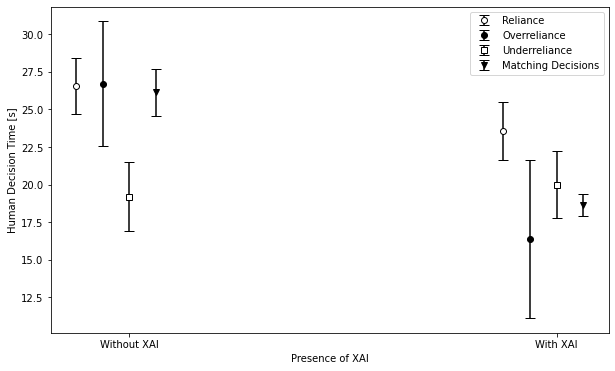

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

reliance_groups = pd.read_csv('groups.csv')
decision_data = pd.read_csv('decision_times.csv')

def get_XAI(idd):
    if 'X' in idd:
        return 1
    else:
        return 0
    
reliance_groups['XAI_value'] = reliance_groups['ID'].apply(get_XAI)
# save the results to a csv file
reliance_groups.to_csv('groups.csv', index=False)

merged_data = pd.merge(decision_data, reliance_groups[['ID', 'task', 'reliance', 'overreliance', 'underreliance', 'matching_decision']], on=['ID', 'task'], how='inner')

# save the results to a csv file
merged_data.to_csv('decision_times_groups.csv', index=False)

def get_group(group, xai):
    if group == 'undefined':
        return 2 # undefined
    elif (group == '1' or group == 1) and xai == 1:
        return 1 # reliance and xai = True
    elif (group == '1' or group == 1) and xai == 0:
        return 0 # reliance and xai = False
    elif (group == '0' or group == 0) and xai == 1:
        return 10 # no reliance and xai = True
    else:
        return 11 # no reliance and xai = False

# reliance
merged_data['condition_reliance'] = merged_data.apply(lambda row: get_group(row['reliance'], row['XAI_value']), axis=1)
# overreliance
merged_data['condition_overreliance'] = merged_data.apply(lambda row: get_group(row['overreliance'], row['XAI_value']), axis=1)
# underreliance
merged_data['condition_underreliance'] = merged_data.apply(lambda row: get_group(row['underreliance'], row['XAI_value']), axis=1)
# matching decision
merged_data['condition_matching_decision'] = merged_data.apply(lambda row: get_group(row['matching_decision'], row['XAI_value']), axis=1)

# save the results to a csv file
merged_data.to_csv('decision_times_groups.csv', index=False)

merged_data = pd.read_csv('decision_times_groups.csv')
global_results = pd.read_csv('decision_times_global_results.csv')

reliance_o = merged_data[merged_data['condition_reliance'] == 0]
reliance_ox = merged_data[merged_data['condition_reliance'] == 1]
overreliance_o = merged_data[merged_data['condition_overreliance'] == 0]
overreliance_ox = merged_data[merged_data['condition_overreliance'] == 1]
underreliance_o = merged_data[merged_data['condition_underreliance'] == 0]
underreliance_ox = merged_data[merged_data['condition_underreliance'] == 1]
no_underreliance_o = merged_data[merged_data['condition_underreliance'] == 11]
no_underreliance_ox = merged_data[merged_data['condition_underreliance'] == 10]
matching_o = merged_data[merged_data['condition_matching_decision'] == 0]
matching_ox = merged_data[merged_data['condition_matching_decision'] == 1]

def mean(df, column):
    mean = df[column].mean()
    return mean
def sem(df, column):
    sem = df[column].std(ddof=1) / np.sqrt(len(df))
    return sem

reliance_o_mean = mean(reliance_o, 'human_decision_time')
reliance_o_sem = sem(reliance_o, 'human_decision_time')
reliance_ox_mean = mean(reliance_ox, 'human_decision_time')
reliance_ox_sem = sem(reliance_ox, 'human_decision_time')

overreliance_o_mean = mean(overreliance_o, 'human_decision_time')
overreliance_o_sem = sem(overreliance_o, 'human_decision_time')
overreliance_ox_mean = mean(overreliance_ox, 'human_decision_time')
overreliance_ox_sem = sem(overreliance_ox, 'human_decision_time')

underreliance_o_mean = mean(underreliance_o, 'human_decision_time')
underreliance_o_sem = sem(underreliance_o, 'human_decision_time')
underreliance_ox_mean = mean(underreliance_ox, 'human_decision_time')
underreliance_ox_sem = sem(underreliance_ox, 'human_decision_time')

no_underreliance_o_mean = mean(no_underreliance_o, 'human_decision_time')
no_underreliance_o_sem = sem(no_underreliance_o, 'human_decision_time')
no_underreliance_ox_mean = mean(no_underreliance_ox, 'human_decision_time')
no_underreliance_ox_sem = sem(no_underreliance_ox, 'human_decision_time')

matching_o_mean = mean(matching_o, 'human_decision_time')
matching_o_sem = sem(matching_o, 'human_decision_time')
matching_ox_mean = mean(matching_ox, 'human_decision_time')
matching_ox_sem = sem(matching_ox, 'human_decision_time')

positions = [1.5, 9.5]
labels = ['Without XAI', 'With XAI']


y_index = [0.5, 8.5]
y_index_2 = [1, 9]
y_index_3 = [1.5, 9.5]
y_index_4 = [2, 10]

plt.figure(figsize=(10, 6))

# Reliance in XAI = True and False
plt.errorbar(y_index, [reliance_o_mean, reliance_ox_mean],\
              [reliance_o_sem, reliance_ox_sem], \
             color='black', marker = 'o', markeredgecolor = 'black', markerfacecolor = 'white', ls = 'none', capsize=5, capthick=1, ecolor='black', label = 'Reliance')

# Overreliance in XAI = True and False
plt.errorbar(y_index_2, [overreliance_o_mean, overreliance_ox_mean],\
                [overreliance_o_sem, overreliance_ox_sem], \
             markeredgecolor = 'black', color='black', marker = 'o', ls='none', capsize=5, capthick=1, ecolor='black', label = 'Overreliance')

# Underreliance in XAI = True and False
plt.errorbar(y_index_3, [underreliance_o_mean, underreliance_ox_mean],\
                [underreliance_o_sem, underreliance_ox_sem], \
             markeredgecolor = 'black', color='black', markerfacecolor = 'white', marker='s', ls='none', capsize=5, capthick=1, ecolor='black', label = 'Underreliance')

# Matching in XAI = True and False
plt.errorbar(y_index_4, [matching_o_mean, matching_ox_mean],\
                 [matching_o_sem, matching_ox_sem], \
             markeredgecolor = 'black', color='black', marker = 'v', ls='none', capsize=5, capthick=1, ecolor='black', label = 'Matching Decisions')

plt.legend()
plt.ylabel('Human Decision Time [s]')
plt.xlabel('Presence of XAI')
plt.xticks(positions, labels)
plt.savefig('human_decision_by_groups_boxplot.pdf', dpi = 600, bbox_inches='tight')
plt.show()






### Human AI decision time by boxplot reliance groups

7.888888888888889 19.0
8.263157894736842 29.176470588235293
7.987654320987654 20.65714285714286


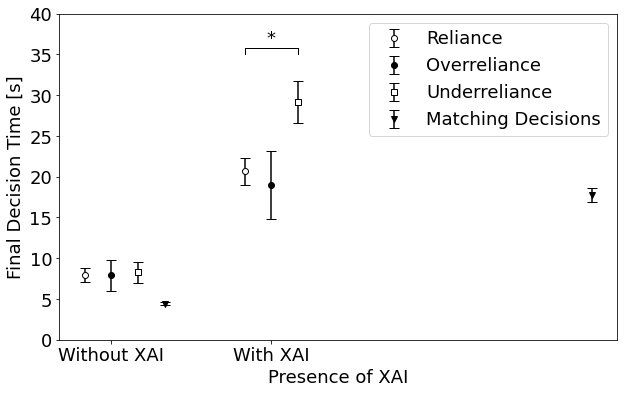

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
merged_data = pd.read_csv('decision_times_groups.csv')
global_results = pd.read_csv('decision_times_global_results.csv')

reliance_o = merged_data[merged_data['condition_reliance'] == 0] # reliance and xai = False
only_reliance_o = reliance_o[reliance_o['overreliance'] != 1] # overreliance and xai = False
reliance_ox = merged_data[merged_data['condition_reliance'] == 1] # reliance and xai = True
only_reliance_ox = reliance_ox[reliance_ox['overreliance'] != 1] # overreliance and xai = True

overreliance_o = merged_data[merged_data['condition_overreliance'] == 0]
overreliance_ox = merged_data[merged_data['condition_overreliance'] == 1]

underreliance_o = merged_data[merged_data['condition_underreliance'] == 0]
underreliance_ox = merged_data[merged_data['condition_underreliance'] == 1]

no_underreliance_o = merged_data[merged_data['condition_underreliance'] == 11]
no_underreliance_ox = merged_data[merged_data['condition_underreliance'] == 10]
matching_o = merged_data[merged_data['condition_matching_decision'] == 0]
matching_ox = merged_data[merged_data['condition_matching_decision'] == 1]


def mean(df, column):
    mean = df[column].mean()
    return mean
def sem(df, column):
    sem = df[column].std(ddof=1) / np.sqrt(len(df))
    return sem


reliance_o_mean = mean(reliance_o, 'human_decision_time')
reliance_o_sem = sem(reliance_o, 'human_decision_time')
reliance_ox_mean = mean(reliance_ox, 'human_decision_time')
reliance_ox_sem = sem(reliance_ox, 'human_decision_time')

only_reliance_o_mean = mean(only_reliance_o, 'human_decision_time')
only_reliance_o_sem = sem(only_reliance_o, 'human_decision_time')
only_reliance_ox_mean = mean(only_reliance_ox, 'human_decision_time')
only_reliance_ox_sem = sem(only_reliance_ox, 'human_decision_time')

overreliance_o_mean = mean(overreliance_o, 'human_decision_time')
overreliance_o_sem = sem(overreliance_o, 'human_decision_time')
overreliance_ox_mean = mean(overreliance_ox, 'human_decision_time')
overreliance_ox_sem = sem(overreliance_ox, 'human_decision_time')

underreliance_o_mean = mean(underreliance_o, 'human_decision_time')
underreliance_o_sem = sem(underreliance_o, 'human_decision_time')
underreliance_ox_mean = mean(underreliance_ox, 'human_decision_time')
underreliance_ox_sem = sem(underreliance_ox, 'human_decision_time')

no_underreliance_o_mean = mean(no_underreliance_o, 'human_decision_time')
no_underreliance_o_sem = sem(no_underreliance_o, 'human_decision_time')
no_underreliance_ox_mean = mean(no_underreliance_ox, 'human_decision_time')
no_underreliance_ox_sem = sem(no_underreliance_ox, 'human_decision_time')

# AI
reliance_o_mean_ai = mean(reliance_o, 'human_ai_decision_time')
reliance_o_sem_ai = sem(reliance_o, 'human_ai_decision_time')
reliance_ox_mean_ai = mean(reliance_ox, 'human_ai_decision_time')
reliance_ox_sem_ai = sem(reliance_ox, 'human_ai_decision_time')

only_reliance_o_mean_ai = mean(only_reliance_o, 'human_ai_decision_time')
only_reliance_o_sem_ai = sem(only_reliance_o, 'human_ai_decision_time')
only_reliance_ox_mean_ai = mean(only_reliance_ox, 'human_ai_decision_time')
only_reliance_ox_sem_ai = sem(only_reliance_ox, 'human_ai_decision_time')

overreliance_o_mean_ai = mean(overreliance_o, 'human_ai_decision_time')
overreliance_o_sem_ai = sem(overreliance_o, 'human_ai_decision_time')
overreliance_ox_mean_ai = mean(overreliance_ox, 'human_ai_decision_time')
overreliance_ox_sem_ai = sem(overreliance_ox, 'human_ai_decision_time')

underreliance_o_mean_ai = mean(underreliance_o, 'human_ai_decision_time')
underreliance_o_sem_ai = sem(underreliance_o, 'human_ai_decision_time')
underreliance_ox_mean_ai = mean(underreliance_ox, 'human_ai_decision_time')
underreliance_ox_sem_ai = sem(underreliance_ox, 'human_ai_decision_time')

no_underreliance_o_mean_ai = mean(no_underreliance_o, 'human_ai_decision_time')
no_underreliance_o_sem_ai = sem(no_underreliance_o, 'human_ai_decision_time')
no_underreliance_ox_mean_ai = mean(no_underreliance_ox, 'human_ai_decision_time')
no_underreliance_ox_sem_ai = sem(no_underreliance_ox, 'human_ai_decision_time')

matching_o_mean_ai = mean(matching_o, 'human_ai_decision_time')
matching_o_sem_ai = sem(matching_o, 'human_ai_decision_time')
matching_ox_mean_ai = mean(matching_ox, 'human_ai_decision_time')
matching_ox_sem_ai = sem(matching_ox, 'human_ai_decision_time')

def add_significance(x1, x2, y, h=0.03, significance='*', linewidth=1, color='k'):
    """
    Add a significance bar between two x positions on the given axis.

    Parameters:
    - ax: The axis (subplot) to plot on.
    - x1, x2: The x coordinates of the two groups being compared.
    - y: The y coordinate (height) where the bar should be placed. altura
    - h: Height of the little 'bump' on the bar. width
    - significance: The string to place on the bar (e.g., '', '*', 'n.s.').
    - linewidth: The width of the line.
    - color: Color of the line and text.
    """
    plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], linewidth=linewidth, color=color)
    plt.text((x1+x2)*.5, y+h, significance, ha='center', va='bottom', color=color)


positions = [1, 4]
labels = ['Without XAI', 'With XAI']

y_index = [0.5, 3.5]
y_index_2 = [1, 4]
y_index_3 = [1.5, 4.5]

plt.figure(figsize=(10, 6))

# font 
plt.rcParams.update({'font.size': 18})


# Reliance in XAI = True and False
plt.errorbar(y_index, [only_reliance_o_mean_ai, only_reliance_ox_mean_ai],\
              [only_reliance_o_sem_ai, only_reliance_ox_sem_ai], \
             color='black', marker = 'o', markeredgecolor = 'black', markerfacecolor = 'white', ls = 'none', capsize=5, capthick=1, ecolor='black', label = 'Reliance')

# Overreliance in XAI = True and False
plt.errorbar(y_index_2, [overreliance_o_mean_ai, overreliance_ox_mean_ai],\
                [overreliance_o_sem_ai, overreliance_ox_sem_ai], \
             markeredgecolor = 'black', color='black', marker = 'o', ls='none', capsize=5, capthick=1, ecolor='black', label = 'Overreliance')

# Underreliance in XAI = True and False
plt.errorbar(y_index_3, [underreliance_o_mean_ai, underreliance_ox_mean_ai],\
                [underreliance_o_sem_ai, underreliance_ox_sem_ai], \
             markeredgecolor = 'black', color='black', markerfacecolor = 'white', marker='s', ls='none', capsize=5, capthick=1, ecolor='black', label = 'Underreliance')

 # Matching in XAI = True and False
plt.errorbar(y_index_4, [matching_o_mean_ai, matching_ox_mean_ai],\
                  [matching_o_sem_ai, matching_ox_sem_ai], \
              markeredgecolor = 'black', color='black', marker = 'v', ls='none', capsize=5, capthick=1, ecolor='black', label = 'Matching Decisions')

print(overreliance_o_mean_ai, overreliance_ox_mean_ai)
print(underreliance_o_mean_ai, underreliance_ox_mean_ai)
print(only_reliance_o_mean_ai, only_reliance_ox_mean_ai)  

add_significance(x1 = 3.5, x2 = 4.5, y = 35, significance = '*', h = 0.8)

plt.legend()
plt.ylabel('Final Decision Time [s]')
plt.ylim(0, 40)
plt.xlabel('Presence of XAI')
plt.xticks(positions, labels)
plt.savefig('ai_decision_by_groups_boxplot.pdf', dpi = 600, bbox_inches='tight')
plt.show()



# Normalized Human-Ai decision time BOXPLOT


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
merged_data = pd.read_csv('mushroom_data/decision_times_reliance_groups.csv')
global_results = pd.read_csv('mushroom_data/decision_times_global_results.csv')

reliance_o = merged_data[merged_data['condition_reliance'] == 0]
reliance_ox = merged_data[merged_data['condition_reliance'] == 1]
overreliance_o = merged_data[merged_data['condition_overreliance'] == 0]
overreliance_ox = merged_data[merged_data['condition_overreliance'] == 1]
underreliance_o = merged_data[merged_data['condition_underreliance'] == 0]
underreliance_ox = merged_data[merged_data['condition_underreliance'] == 1]
no_underreliance_o = merged_data[merged_data['condition_underreliance'] == 11]
no_underreliance_ox = merged_data[merged_data['condition_underreliance'] == 10]


def mean(df, column):
    mean = df[column].mean()
    return mean
def sem(df, column):
    sem = df[column].std(ddof=1) / np.sqrt(len(df))
    return sem

reliance_o_mean = mean(reliance_o, 'human_decision_time')
reliance_o_sem = sem(reliance_o, 'human_decision_time')
reliance_ox_mean = mean(reliance_ox, 'human_decision_time')
reliance_ox_sem = sem(reliance_ox, 'human_decision_time')

overreliance_o_mean = mean(overreliance_o, 'human_decision_time')
overreliance_o_sem = sem(overreliance_o, 'human_decision_time')
overreliance_ox_mean = mean(overreliance_ox, 'human_decision_time')
overreliance_ox_sem = sem(overreliance_ox, 'human_decision_time')

underreliance_o_mean = mean(underreliance_o, 'human_decision_time')
underreliance_o_sem = sem(underreliance_o, 'human_decision_time')
underreliance_ox_mean = mean(underreliance_ox, 'human_decision_time')
underreliance_ox_sem = sem(underreliance_ox, 'human_decision_time')

no_underreliance_o_mean = mean(no_underreliance_o, 'human_decision_time')
no_underreliance_o_sem = sem(no_underreliance_o, 'human_decision_time')
no_underreliance_ox_mean = mean(no_underreliance_ox, 'human_decision_time')
no_underreliance_ox_sem = sem(no_underreliance_ox, 'human_decision_time')

# AI
reliance_o_mean_ai = mean(reliance_o, 'human_ai_decision_time')
reliance_o_sem_ai = sem(reliance_o, 'human_ai_decision_time')
reliance_ox_mean_ai = mean(reliance_ox, 'human_ai_decision_time')
reliance_ox_sem_ai = sem(reliance_ox, 'human_ai_decision_time')

overreliance_o_mean_ai = mean(overreliance_o, 'human_ai_decision_time')
overreliance_o_sem_ai = sem(overreliance_o, 'human_ai_decision_time')
overreliance_ox_mean_ai = mean(overreliance_ox, 'human_ai_decision_time')
overreliance_ox_sem_ai = sem(overreliance_ox, 'human_ai_decision_time')

underreliance_o_mean_ai = mean(underreliance_o, 'human_ai_decision_time')
underreliance_o_sem_ai = sem(underreliance_o, 'human_ai_decision_time')
underreliance_ox_mean_ai = mean(underreliance_ox, 'human_ai_decision_time')
underreliance_ox_sem_ai = sem(underreliance_ox, 'human_ai_decision_time')

no_underreliance_o_mean_ai = mean(no_underreliance_o, 'human_ai_decision_time')
no_underreliance_o_sem_ai = sem(no_underreliance_o, 'human_ai_decision_time')
no_underreliance_ox_mean_ai = mean(no_underreliance_ox, 'human_ai_decision_time')
no_underreliance_ox_sem_ai = sem(no_underreliance_ox, 'human_ai_decision_time')

global_human_decision_time_o = np.array(global_results['human_decision_time_mean_0'])
global_human_decision_time_ox = np.array(global_results['human_decision_time_mean_1'])
global_human_decision_time_o_sem = np.array(global_results['human_decision_time_sem_0'])
global_human_decision_time_ox_sem = np.array(global_results['human_decision_time_sem_1'])

# SEM = X*sqrt((SEM_X/X)**2 + (SEM_Y/Y)**2)/Y (X/Y)

normalized_reliance_sem_o = reliance_o_mean_ai*np.array(np.sqrt((global_human_decision_time_o_sem/global_human_decision_time_o)**2 + (reliance_o_sem_ai/reliance_o_mean_ai)**2)/global_human_decision_time_o)
normalized_reliance_sem_ox = reliance_o_mean_ai*np.array(np.sqrt((global_human_decision_time_ox_sem/global_human_decision_time_ox)**2 + (reliance_ox_sem_ai/reliance_ox_mean_ai)**2)/global_human_decision_time_ox)

print('Reliance O: ', normalized_reliance_sem_o)
print('Reliance OX: ', normalized_reliance_sem_ox)

normalized_overreliance_sem_o = overreliance_o_mean_ai*np.array(np.sqrt((global_human_decision_time_o_sem/global_human_decision_time_o)**2 + (overreliance_o_sem_ai/overreliance_o_mean_ai)**2)/global_human_decision_time_o)
normalized_overreliance_sem_ox = overreliance_ox_mean_ai*np.array(np.sqrt((global_human_decision_time_ox_sem/global_human_decision_time_ox)**2 + (overreliance_ox_sem_ai/overreliance_ox_mean_ai)**2)/global_human_decision_time_ox)

normalized_underreliance_sem_o = underreliance_o_mean_ai*np.array(np.sqrt((global_human_decision_time_o_sem/global_human_decision_time_o)**2 + (underreliance_o_sem_ai/underreliance_o_mean_ai)**2)/global_human_decision_time_o)
normalized_underreliance_sem_ox = underreliance_ox_mean_ai*np.array(np.sqrt((global_human_decision_time_ox_sem/global_human_decision_time_ox)**2 + (underreliance_ox_sem_ai/underreliance_ox_mean_ai)**2)/global_human_decision_time_ox)


normalized_no_underreliance_sem_o = no_underreliance_o_mean_ai*np.array(np.sqrt((global_human_decision_time_o_sem/global_human_decision_time_o)**2 + (no_underreliance_o_sem_ai/no_underreliance_o_mean_ai)**2)/global_human_decision_time_o)
normalized_no_underreliance_sem_ox = no_underreliance_ox_mean_ai*np.array(np.sqrt((global_human_decision_time_ox_sem/global_human_decision_time_ox)**2 + (no_underreliance_ox_sem_ai/no_underreliance_ox_mean_ai)**2)/global_human_decision_time_ox)

normalized_reliance_o = np.array(reliance_o_mean_ai/global_human_decision_time_o)
normalized_reliance_ox = np.array(reliance_ox_mean_ai/global_human_decision_time_ox)
normalized_overreliance_o = np.array(overreliance_o_mean_ai/global_human_decision_time_o)
normalized_overreliance_ox = np.array(overreliance_ox_mean_ai/global_human_decision_time_ox)
normalized_underreliance_o = np.array(underreliance_o_mean_ai/global_human_decision_time_o)
normalized_underreliance_ox = np.array(underreliance_ox_mean_ai/global_human_decision_time_ox)
normalized_no_underreliance_o = np.array(no_underreliance_o_mean_ai/global_human_decision_time_o)
normalized_no_underreliance_ox = np.array(no_underreliance_ox_mean_ai/global_human_decision_time_ox)

positions = [1.5, 9.5]
labels = ['False', 'True']

y_index = [0.5, 8.5]
y_index_2 = [1, 9]
y_index_3 = [1.5, 9.5]
y_index_4 = [2, 10]

plt.figure(figsize=(10, 6))

# Reliance in XAI = True and False

# convert to scalar values


normalized_reliance_sem_o = normalized_reliance_sem_o.item()
normalized_reliance_sem_ox = normalized_reliance_sem_ox.item()
normalized_reliance_o = normalized_reliance_o.item()
normalized_reliance_ox = normalized_reliance_ox.item()

plt.errorbar(y_index, [normalized_reliance_o, normalized_reliance_ox],\
                [normalized_reliance_sem_o, normalized_reliance_sem_ox], \
             color='black', marker = 'o', markeredgecolor = 'black', markerfacecolor = 'white', ls = 'none', capsize=5, linewidth = 1, capthick=1, ecolor='black', label = 'Reliance')

print('Reliance O: ', normalized_reliance_o)
print('Reliance OX: ', normalized_reliance_ox)
print('SEM Reliance O: ', normalized_reliance_sem_o)
print('SEM Reliance OX: ', normalized_reliance_sem_ox)

# Overreliance in XAI = True and False

normalized_overreliance_sem_ox = normalized_overreliance_sem_ox.item()
normalized_overreliance_sem_o = normalized_overreliance_sem_o.item()
normalized_overreliance_o = normalized_overreliance_o.item()
normalized_overreliance_ox = normalized_overreliance_ox.item()


plt.errorbar(y_index_2, 
                [normalized_overreliance_o, normalized_overreliance_ox],\
                [normalized_overreliance_sem_o, normalized_overreliance_sem_ox], \
             markeredgecolor = 'black', color='black', marker = 'o', ls='none', capsize=5, capthick=1, ecolor='black', label = 'Overreliance')

print('Overreliance O: ', normalized_overreliance_o)
print('Overreliance OX: ', normalized_overreliance_ox)
print('SEM Overreliance O: ', normalized_overreliance_sem_o)
print('SEM Overreliance OX: ', normalized_overreliance_sem_ox)

# Underreliance in XAI = True and False

normalized_underreliance_o = normalized_underreliance_o.item()
normalized_underreliance_ox = normalized_underreliance_ox.item()
normalized_underreliance_sem_o = normalized_underreliance_sem_o.item()
normalized_underreliance_sem_ox = normalized_underreliance_sem_ox.item()

plt.errorbar(y_index_3, 
                [normalized_underreliance_o, normalized_underreliance_ox],\
                [normalized_underreliance_sem_o, normalized_underreliance_sem_ox], \
             markeredgecolor = 'black', color='black', markerfacecolor = 'white', marker='s', ls='none', capsize=5, capthick=1, ecolor='black', label = 'Underreliance')

print('Underreliance O: ', normalized_underreliance_o)
print('Underreliance OX: ', normalized_underreliance_ox)
print('SEM Underreliance O: ', normalized_underreliance_sem_o)
print('SEM Underreliance OX: ', normalized_underreliance_sem_ox)


# No Underreliance in XAI = True and False

normalized_no_underreliance_o = normalized_no_underreliance_o.item()
normalized_no_underreliance_ox = normalized_no_underreliance_ox.item()
normalized_no_underreliance_sem_o = normalized_no_underreliance_sem_o.item()
normalized_no_underreliance_sem_ox = normalized_no_underreliance_sem_ox.item()


# plt.errorbar(y_index_4,
#                [normalized_no_underreliance_o, normalized_no_underreliance_ox],\
#                 [normalized_no_underreliance_sem_o, normalized_no_underreliance_sem_ox], \
#              markeredgecolor = 'black', color='black', marker = 'v', ls='none', capsize=5, capthick=1, ecolor='black', label = 'No Underreliance')

print('No Underreliance O: ', normalized_no_underreliance_o)
print('No Underreliance OX: ', normalized_no_underreliance_ox)
print('SEM No Underreliance O: ', normalized_no_underreliance_sem_o)
print('SEM No Underreliance OX: ', normalized_no_underreliance_sem_ox)

plt.legend()
plt.ylabel('Human-AI Decision Time / Human Decision Time')
plt.xlabel('XAI Model')
plt.xticks(positions, labels)
plt.savefig('reliance_images/normalized_ai_decision_by_reliance_boxplot.png', dpi = 1600, bbox_inches='tight')
plt.savefig('reliance_images/normalized_ai_decision_by_reliance_boxplot.svg', dpi = 1600, bbox_inches='tight')
plt.show()




### Subtraction of XAI Duration

In [ ]:
import numpy as np
import pandas as pd

reliance_groups = pd.read_csv('gaze_data/reliance_groups/groups.csv')
decision_data = pd.read_csv('mushroom_data/decision_times_subtracted.csv')
def get_XAI(idd):
    if 'X' in idd:
        return 1
    else:
        return 0
    
reliance_groups['XAI_value'] = reliance_groups['ID'].apply(get_XAI)
# save the results to a csv file
reliance_groups.to_csv('mushroom_data/reliance_groups.csv', index=False)

merged_data = pd.merge(decision_data, reliance_groups[['ID', 'task', 'reliance', 'overreliance', 'underreliance']], on=['ID', 'task'], how='inner')

# save the results to a csv file
merged_data.to_csv('mushroom_data/subtracted_decision_times_reliance_groups.csv', index=False)

def get_group(group, xai):
    if group == 'undefined':
        return 2 # undefined
    elif group == '1' and xai == 1:
        return 1 # reliance and xai = True
    elif group == '1' and xai == 0:
        return 0 # reliance and xai = False
    elif group == '0' and xai == 1:
        return 10 # no reliance and xai = True
    else:
        return 11 # no reliance and xai = False

# reliance
merged_data['condition_reliance'] = merged_data.apply(lambda row: get_group(row['reliance'], row['XAI_value']), axis=1)
# overreliance
merged_data['condition_overreliance'] = merged_data.apply(lambda row: get_group(row['overreliance'], row['XAI_value']), axis=1)
# underreliance
merged_data['condition_underreliance'] = merged_data.apply(lambda row: get_group(row['underreliance'], row['XAI_value']), axis=1)

# save the results to a csv file
merged_data.to_csv('mushroom_data/subtracted_decision_times_reliance_groups.csv', index=False)

merged_data = pd.read_csv('mushroom_data/subtracted_decision_times_reliance_groups.csv')
global_results = pd.read_csv('mushroom_data/subtracted_decision_times_global_results.csv')

reliance_o = merged_data[merged_data['condition_reliance'] == 0]
reliance_ox = merged_data[merged_data['condition_reliance'] == 1]
overreliance_o = merged_data[merged_data['condition_overreliance'] == 0]
overreliance_ox = merged_data[merged_data['condition_overreliance'] == 1]
underreliance_o = merged_data[merged_data['condition_underreliance'] == 0]
underreliance_ox = merged_data[merged_data['condition_underreliance'] == 1]
no_underreliance_o = merged_data[merged_data['condition_underreliance'] == 11]
no_underreliance_ox = merged_data[merged_data['condition_underreliance'] == 10]


def mean(df, column):
    mean = df[column].mean()
    return mean
def sem(df, column):
    sem = df[column].std(ddof=1) / np.sqrt(len(df))
    return sem

reliance_o_mean = mean(reliance_o, 'human_decision_time')
reliance_o_sem = sem(reliance_o, 'human_decision_time')
reliance_ox_mean = mean(reliance_ox, 'human_decision_time')
reliance_ox_sem = sem(reliance_ox, 'human_decision_time')

overreliance_o_mean = mean(overreliance_o, 'human_decision_time')
overreliance_o_sem = sem(overreliance_o, 'human_decision_time')
overreliance_ox_mean = mean(overreliance_ox, 'human_decision_time')
overreliance_ox_sem = sem(overreliance_ox, 'human_decision_time')

underreliance_o_mean = mean(underreliance_o, 'human_decision_time')
underreliance_o_sem = sem(underreliance_o, 'human_decision_time')
underreliance_ox_mean = mean(underreliance_ox, 'human_decision_time')
underreliance_ox_sem = sem(underreliance_ox, 'human_decision_time')

no_underreliance_o_mean = mean(no_underreliance_o, 'human_decision_time')
no_underreliance_o_sem = sem(no_underreliance_o, 'human_decision_time')
no_underreliance_ox_mean = mean(no_underreliance_ox, 'human_decision_time')
no_underreliance_ox_sem = sem(no_underreliance_ox, 'human_decision_time')

positions = [1.5, 9.5]
labels = ['False', 'True']

y_index = [0.5, 8.5]
y_index_2 = [1, 9]
y_index_3 = [1.5, 9.5]
y_index_4 = [2, 10]

plt.figure(figsize=(10, 6))

# Reliance in XAI = True and False
plt.errorbar(y_index, [reliance_o_mean, reliance_ox_mean],\
              [reliance_o_sem, reliance_ox_sem], \
             color='black', marker = 'o', markeredgecolor = 'black', markerfacecolor = 'white', ls = 'none', capsize=5, capthick=1, ecolor='black', label = 'Reliance')

# Overreliance in XAI = True and False
plt.errorbar(y_index_2, [overreliance_o_mean, overreliance_ox_mean],\
                [overreliance_o_sem, overreliance_ox_sem], \
             markeredgecolor = 'black', color='black', marker = 'o', ls='none', capsize=5, capthick=1, ecolor='black', label = 'Overreliance')

# Underreliance in XAI = True and False
plt.errorbar(y_index_3, [underreliance_o_mean, underreliance_ox_mean],\
                [underreliance_o_sem, underreliance_ox_sem], \
             markeredgecolor = 'black', color='black', markerfacecolor = 'white', marker='s', ls='none', capsize=5, capthick=1, ecolor='black', label = 'Underreliance')


plt.legend()
plt.ylabel('Human Decision Time [s]')
plt.xlabel('XAI Model')
plt.xticks(positions, labels)
plt.savefig('reliance_images/subtracted_human_decision_by_reliance_boxplot.png', dpi = 1600, bbox_inches='tight')
plt.show()





### Human-AI Subtracted Box plot

In [ ]:
import numpy as np
import pandas as pd
merged_data = pd.read_csv('mushroom_data/subtracted_decision_times_reliance_groups.csv')
global_results = pd.read_csv('mushroom_data/subtracted_decision_times_global_results.csv')

reliance_o = merged_data[merged_data['condition_reliance'] == 0]
reliance_ox = merged_data[merged_data['condition_reliance'] == 1]
overreliance_o = merged_data[merged_data['condition_overreliance'] == 0]
overreliance_ox = merged_data[merged_data['condition_overreliance'] == 1]
underreliance_o = merged_data[merged_data['condition_underreliance'] == 0]
underreliance_ox = merged_data[merged_data['condition_underreliance'] == 1]
no_underreliance_o = merged_data[merged_data['condition_underreliance'] == 11]
no_underreliance_ox = merged_data[merged_data['condition_underreliance'] == 10]


def mean(df, column):
    mean = df[column].mean()
    return mean
def sem(df, column):
    sem = df[column].std(ddof=1) / np.sqrt(len(df))
    return sem

reliance_o_mean = mean(reliance_o, 'human_decision_time')
reliance_o_sem = sem(reliance_o, 'human_decision_time')
reliance_ox_mean = mean(reliance_ox, 'human_decision_time')
reliance_ox_sem = sem(reliance_ox, 'human_decision_time')

overreliance_o_mean = mean(overreliance_o, 'human_decision_time')
overreliance_o_sem = sem(overreliance_o, 'human_decision_time')
overreliance_ox_mean = mean(overreliance_ox, 'human_decision_time')
overreliance_ox_sem = sem(overreliance_ox, 'human_decision_time')

underreliance_o_mean = mean(underreliance_o, 'human_decision_time')
underreliance_o_sem = sem(underreliance_o, 'human_decision_time')
underreliance_ox_mean = mean(underreliance_ox, 'human_decision_time')
underreliance_ox_sem = sem(underreliance_ox, 'human_decision_time')

no_underreliance_o_mean = mean(no_underreliance_o, 'human_decision_time')
no_underreliance_o_sem = sem(no_underreliance_o, 'human_decision_time')
no_underreliance_ox_mean = mean(no_underreliance_ox, 'human_decision_time')
no_underreliance_ox_sem = sem(no_underreliance_ox, 'human_decision_time')

# AI
reliance_o_mean_ai = mean(reliance_o, 'subtracted_human_ai_decision_time')
reliance_o_sem_ai = sem(reliance_o, 'subtracted_human_ai_decision_time')
reliance_ox_mean_ai = mean(reliance_ox, 'subtracted_human_ai_decision_time')
reliance_ox_sem_ai = sem(reliance_ox, 'subtracted_human_ai_decision_time')

overreliance_o_mean_ai = mean(overreliance_o, 'subtracted_human_ai_decision_time')
overreliance_o_sem_ai = sem(overreliance_o, 'subtracted_human_ai_decision_time')
overreliance_ox_mean_ai = mean(overreliance_ox, 'subtracted_human_ai_decision_time')
overreliance_ox_sem_ai = sem(overreliance_ox, 'subtracted_human_ai_decision_time')

underreliance_o_mean_ai = mean(underreliance_o, 'subtracted_human_ai_decision_time')
underreliance_o_sem_ai = sem(underreliance_o, 'subtracted_human_ai_decision_time')
underreliance_ox_mean_ai = mean(underreliance_ox, 'subtracted_human_ai_decision_time')
underreliance_ox_sem_ai = sem(underreliance_ox, 'subtracted_human_ai_decision_time')

no_underreliance_o_mean_ai = mean(no_underreliance_o, 'subtracted_human_ai_decision_time')
no_underreliance_o_sem_ai = sem(no_underreliance_o, 'subtracted_human_ai_decision_time')
no_underreliance_ox_mean_ai = mean(no_underreliance_ox, 'subtracted_human_ai_decision_time')
no_underreliance_ox_sem_ai = sem(no_underreliance_ox, 'subtracted_human_ai_decision_time')


positions = [1.5, 9.5]
labels = ['False', 'True']

y_index = [0.5, 8.5]
y_index_2 = [1, 9]
y_index_3 = [1.5, 9.5]
y_index_4 = [2, 10]

plt.figure(figsize=(10, 6))

# Reliance in XAI = True and False
plt.errorbar(y_index, [reliance_o_mean_ai, reliance_ox_mean_ai],\
              [reliance_o_sem_ai, reliance_ox_sem_ai], \
             color='black', marker = 'o', markeredgecolor = 'black', markerfacecolor = 'white', ls = 'none', capsize=5, capthick=1, ecolor='black', label = 'Reliance')

# Overreliance in XAI = True and False
plt.errorbar(y_index_2, [overreliance_o_mean_ai, overreliance_ox_mean_ai],\
                [overreliance_o_sem_ai, overreliance_ox_sem_ai], \
             markeredgecolor = 'black', color='black', marker = 'o', ls='none', capsize=5, capthick=1, ecolor='black', label = 'Overreliance')

# Underreliance in XAI = True and False
plt.errorbar(y_index_3, [underreliance_o_mean_ai, underreliance_ox_mean_ai],\
                [underreliance_o_sem_ai, underreliance_ox_sem_ai], \
             markeredgecolor = 'black', color='black', markerfacecolor = 'white', marker='s', ls='none', capsize=5, capthick=1, ecolor='black', label = 'Underreliance')


plt.legend()
plt.ylabel('Human-AI Reasoning Time [s]')
plt.xlabel('XAI Model')
plt.xticks(positions, labels)
plt.savefig('reliance_images/subtracted_ai_decision_by_reliance_boxplot.png', dpi = 1600, bbox_inches='tight')
plt.show()

### Reasoning time Normalized 

In [ ]:
import numpy as np
import pandas as pd
merged_data = pd.read_csv('mushroom_data/subtracted_decision_times_reliance_groups.csv')
global_results = pd.read_csv('mushroom_data/subtracted_decision_times_global_results.csv')

reliance_o = merged_data[merged_data['condition_reliance'] == 0]
reliance_ox = merged_data[merged_data['condition_reliance'] == 1]
overreliance_o = merged_data[merged_data['condition_overreliance'] == 0]
overreliance_ox = merged_data[merged_data['condition_overreliance'] == 1]
underreliance_o = merged_data[merged_data['condition_underreliance'] == 0]
underreliance_ox = merged_data[merged_data['condition_underreliance'] == 1]
no_underreliance_o = merged_data[merged_data['condition_underreliance'] == 11]
no_underreliance_ox = merged_data[merged_data['condition_underreliance'] == 10]


def mean(df, column):
    mean = df[column].mean()
    return mean
def sem(df, column):
    sem = df[column].std(ddof=1) / np.sqrt(len(df))
    return sem

reliance_o_mean = mean(reliance_o, 'human_decision_time')
reliance_o_sem = sem(reliance_o, 'human_decision_time')
reliance_ox_mean = mean(reliance_ox, 'human_decision_time')
reliance_ox_sem = sem(reliance_ox, 'human_decision_time')

overreliance_o_mean = mean(overreliance_o, 'human_decision_time')
overreliance_o_sem = sem(overreliance_o, 'human_decision_time')
overreliance_ox_mean = mean(overreliance_ox, 'human_decision_time')
overreliance_ox_sem = sem(overreliance_ox, 'human_decision_time')

underreliance_o_mean = mean(underreliance_o, 'human_decision_time')
underreliance_o_sem = sem(underreliance_o, 'human_decision_time')
underreliance_ox_mean = mean(underreliance_ox, 'human_decision_time')
underreliance_ox_sem = sem(underreliance_ox, 'human_decision_time')

no_underreliance_o_mean = mean(no_underreliance_o, 'human_decision_time')
no_underreliance_o_sem = sem(no_underreliance_o, 'human_decision_time')
no_underreliance_ox_mean = mean(no_underreliance_ox, 'human_decision_time')
no_underreliance_ox_sem = sem(no_underreliance_ox, 'human_decision_time')

# AI
reliance_o_mean_ai = mean(reliance_o, 'subtracted_human_ai_decision_time')
reliance_o_sem_ai = sem(reliance_o, 'subtracted_human_ai_decision_time')
reliance_ox_mean_ai = mean(reliance_ox, 'subtracted_human_ai_decision_time')
reliance_ox_sem_ai = sem(reliance_ox, 'subtracted_human_ai_decision_time')

overreliance_o_mean_ai = mean(overreliance_o, 'subtracted_human_ai_decision_time')
overreliance_o_sem_ai = sem(overreliance_o, 'subtracted_human_ai_decision_time')
overreliance_ox_mean_ai = mean(overreliance_ox, 'subtracted_human_ai_decision_time')
overreliance_ox_sem_ai = sem(overreliance_ox, 'subtracted_human_ai_decision_time')

underreliance_o_mean_ai = mean(underreliance_o, 'subtracted_human_ai_decision_time')
underreliance_o_sem_ai = sem(underreliance_o, 'subtracted_human_ai_decision_time')
underreliance_ox_mean_ai = mean(underreliance_ox, 'subtracted_human_ai_decision_time')
underreliance_ox_sem_ai = sem(underreliance_ox, 'subtracted_human_ai_decision_time')

no_underreliance_o_mean_ai = mean(no_underreliance_o, 'subtracted_human_ai_decision_time')
no_underreliance_o_sem_ai = sem(no_underreliance_o, 'subtracted_human_ai_decision_time')
no_underreliance_ox_mean_ai = mean(no_underreliance_ox, 'subtracted_human_ai_decision_time')
no_underreliance_ox_sem_ai = sem(no_underreliance_ox, 'subtracted_human_ai_decision_time')

global_human_decision_time_o = np.array(global_results['human_decision_time_mean_0'])
global_human_decision_time_ox = np.array(global_results['human_decision_time_mean_1'])
global_human_decision_time_o_sem = np.array(global_results['human_decision_time_sem_0'])
global_human_decision_time_ox_sem = np.array(global_results['human_decision_time_sem_1'])


# SEM = X*sqrt((SEM_X/X)**2 + (SEM_Y/Y)**2)/Y (X/Y)

normalized_reliance_sem_o = reliance_o_mean_ai*np.array(np.sqrt((global_human_decision_time_o_sem/global_human_decision_time_o)**2 + (reliance_o_sem_ai/reliance_o_mean_ai)**2)/global_human_decision_time_o)
normalized_reliance_sem_ox = reliance_o_mean_ai*np.array(np.sqrt((global_human_decision_time_ox_sem/global_human_decision_time_ox)**2 + (reliance_ox_sem_ai/reliance_ox_mean_ai)**2)/global_human_decision_time_ox)

print('Reliance O: ', normalized_reliance_sem_o)
print('Reliance OX: ', normalized_reliance_sem_ox)

normalized_overreliance_sem_o = overreliance_o_mean_ai*np.array(np.sqrt((global_human_decision_time_o_sem/global_human_decision_time_o)**2 + (overreliance_o_sem_ai/overreliance_o_mean_ai)**2)/global_human_decision_time_o)
normalized_overreliance_sem_ox = overreliance_ox_mean_ai*np.array(np.sqrt((global_human_decision_time_ox_sem/global_human_decision_time_ox)**2 + (overreliance_ox_sem_ai/overreliance_ox_mean_ai)**2)/global_human_decision_time_ox)

normalized_underreliance_sem_o = underreliance_o_mean_ai*np.array(np.sqrt((global_human_decision_time_o_sem/global_human_decision_time_o)**2 + (underreliance_o_sem_ai/underreliance_o_mean_ai)**2)/global_human_decision_time_o)
normalized_underreliance_sem_ox = underreliance_ox_mean_ai*np.array(np.sqrt((global_human_decision_time_ox_sem/global_human_decision_time_ox)**2 + (underreliance_ox_sem_ai/underreliance_ox_mean_ai)**2)/global_human_decision_time_ox)


normalized_no_underreliance_sem_o = no_underreliance_o_mean_ai*np.array(np.sqrt((global_human_decision_time_o_sem/global_human_decision_time_o)**2 + (no_underreliance_o_sem_ai/no_underreliance_o_mean_ai)**2)/global_human_decision_time_o)
normalized_no_underreliance_sem_ox = no_underreliance_ox_mean_ai*np.array(np.sqrt((global_human_decision_time_ox_sem/global_human_decision_time_ox)**2 + (no_underreliance_ox_sem_ai/no_underreliance_ox_mean_ai)**2)/global_human_decision_time_ox)

normalized_reliance_o = np.array(reliance_o_mean_ai/global_human_decision_time_o)
normalized_reliance_ox = np.array(reliance_ox_mean_ai/global_human_decision_time_ox)
normalized_overreliance_o = np.array(overreliance_o_mean_ai/global_human_decision_time_o)
normalized_overreliance_ox = np.array(overreliance_ox_mean_ai/global_human_decision_time_ox)
normalized_underreliance_o = np.array(underreliance_o_mean_ai/global_human_decision_time_o)
normalized_underreliance_ox = np.array(underreliance_ox_mean_ai/global_human_decision_time_ox)
normalized_no_underreliance_o = np.array(no_underreliance_o_mean_ai/global_human_decision_time_o)
normalized_no_underreliance_ox = np.array(no_underreliance_ox_mean_ai/global_human_decision_time_ox)

positions = [1.5, 9.5]
labels = ['False', 'True']

y_index = [0.5, 8.5]
y_index_2 = [1, 9]
y_index_3 = [1.5, 9.5]
y_index_4 = [2, 10]

plt.figure(figsize=(10, 6))

# Reliance in XAI = True and False

# convert to scalar values


normalized_reliance_sem_o = normalized_reliance_sem_o.item()
normalized_reliance_sem_ox = normalized_reliance_sem_ox.item()
normalized_reliance_o = normalized_reliance_o.item()
normalized_reliance_ox = normalized_reliance_ox.item()

plt.errorbar(y_index, [normalized_reliance_o, normalized_reliance_ox],\
                [normalized_reliance_sem_o, normalized_reliance_sem_ox], \
             color='black', marker = 'o', markeredgecolor = 'black', markerfacecolor = 'white', ls = 'none', capsize=5, linewidth = 1, capthick=1, ecolor='black', label = 'Reliance')

print('Reliance O: ', normalized_reliance_o)
print('Reliance OX: ', normalized_reliance_ox)
print('SEM Reliance O: ', normalized_reliance_sem_o)
print('SEM Reliance OX: ', normalized_reliance_sem_ox)

# Overreliance in XAI = True and False

normalized_overreliance_sem_ox = normalized_overreliance_sem_ox.item()
normalized_overreliance_sem_o = normalized_overreliance_sem_o.item()
normalized_overreliance_o = normalized_overreliance_o.item()
normalized_overreliance_ox = normalized_overreliance_ox.item()


plt.errorbar(y_index_2, 
                [normalized_overreliance_o, normalized_overreliance_ox],\
                [normalized_overreliance_sem_o, normalized_overreliance_sem_ox], \
             markeredgecolor = 'black', color='black', marker = 'o', ls='none', capsize=5, capthick=1, ecolor='black', label = 'Overreliance')

print('Overreliance O: ', normalized_overreliance_o)
print('Overreliance OX: ', normalized_overreliance_ox)
print('SEM Overreliance O: ', normalized_overreliance_sem_o)
print('SEM Overreliance OX: ', normalized_overreliance_sem_ox)

# Underreliance in XAI = True and False

normalized_underreliance_o = normalized_underreliance_o.item()
normalized_underreliance_ox = normalized_underreliance_ox.item()
normalized_underreliance_sem_o = normalized_underreliance_sem_o.item()
normalized_underreliance_sem_ox = normalized_underreliance_sem_ox.item()

plt.errorbar(y_index_3, 
                [normalized_underreliance_o, normalized_underreliance_ox],\
                [normalized_underreliance_sem_o, normalized_underreliance_sem_ox], \
             markeredgecolor = 'black', color='black', markerfacecolor = 'white', marker='s', ls='none', capsize=5, capthick=1, ecolor='black', label = 'Underreliance')

print('Underreliance O: ', normalized_underreliance_o)
print('Underreliance OX: ', normalized_underreliance_ox)
print('SEM Underreliance O: ', normalized_underreliance_sem_o)
print('SEM Underreliance OX: ', normalized_underreliance_sem_ox)


# No Underreliance in XAI = True and False

normalized_no_underreliance_o = normalized_no_underreliance_o.item()
normalized_no_underreliance_ox = normalized_no_underreliance_ox.item()
normalized_no_underreliance_sem_o = normalized_no_underreliance_sem_o.item()
normalized_no_underreliance_sem_ox = normalized_no_underreliance_sem_ox.item()

print('No Underreliance O: ', normalized_no_underreliance_o)
print('No Underreliance OX: ', normalized_no_underreliance_ox)
print('SEM No Underreliance O: ', normalized_no_underreliance_sem_o)
print('SEM No Underreliance OX: ', normalized_no_underreliance_sem_ox)

plt.legend()
plt.ylabel('Human-AI Reasoning Time / Human Decision Time')
plt.xlabel('XAI Model')
plt.xticks(positions, labels)
plt.savefig('reliance_images/subtracted_normalized_ai_decision_by_reliance_boxplot.png', dpi = 1600, bbox_inches='tight')
plt.savefig('reliance_images/subtracted_normalized_ai_decision_by_reliance_boxplot.svg', dpi = 1600, bbox_inches='tight')
plt.show()


### Analyze Negative and Positive Groups of Subtracted XAI Duration

Number of Reliance tasks XAI = True:  35  Reliance Domain:  116
Number of Overreliance tasks in XAI = True:  5  Overreliance Domain:  23
Number of Underreliance tasks in XAI = True:  17  Underreliance Domain:  36
Number of Reliance tasks XAI = True with negative subtracted_human_ai_decision 9 Positive:  26
Number of Overreliance tasks XAI = True with negative subtracted_human_ai_decision 1 Positive:  4
Number of Underreliance tasks XAI = True with negative subtracted_human_ai_decision 0 Positive:  17
Total:  215


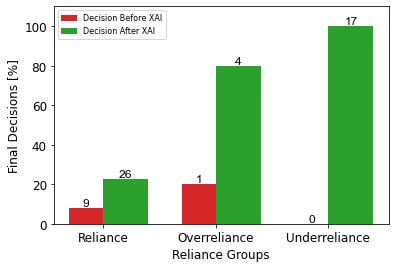

In [59]:
import pandas as pd

# obtain average human decision time and human-ai decision for XAI = 1 and XAI = 0 (from SPSS)
# global results first
# for each task, mean and SEM
import numpy as np
import pandas as pd

decision_data = pd.read_csv('decision_times.csv')

def mean(df, column):
    mean = df[column].mean()
    return mean
def sem(df, column):
    sem = df[column].std(ddof=1) / np.sqrt(len(df))
    return sem

durations = pd.read_csv('XAI_durations.csv')

# Subtract the rec_duration and xai_durations from the human-ai decision time (with the same task) when XAI = 1
# Subtract the rec_duration from the human-ai decision time (with the same task) when XAI = 0
for i in range(len(decision_data)):
    row = decision_data.iloc[i]
    if row['XAI_value'] == 1:
        task = row['task']
        rec_duration = durations[durations['task'] == task]['rec_duration'].values[0]
        xai_duration = durations[durations['task'] == task]['xai_duration'].values[0]
        decision_data.at[i, 'subtracted_human_ai_decision_time'] = row['human_ai_decision_time'] - xai_duration - rec_duration
    else:
        task = row['task']
        rec_duration = durations[durations['task'] == task]['rec_duration'].values[0]
        decision_data.at[i, 'subtracted_human_ai_decision_time'] = row['human_ai_decision_time'] - rec_duration

decision_data.to_csv('decision_times_subtracted_XAI.csv', index=False) 

def get_XAI(idd):
    if 'X' in idd:
        return 1
    else:
        return 0
    

reliance_groups = pd.read_csv('groups.csv')
reliance_groups['XAI_value'] = reliance_groups['ID'].apply(get_XAI)

decision_data = pd.read_csv('decision_times_subtracted_XAI.csv')
# save the results to a csv file

merged_data = pd.merge(decision_data, reliance_groups[['ID', 'task', 'reliance', 'overreliance', 'underreliance', 'matching_decision']], on=['ID', 'task'], how='inner')

# save the results to a csv file
merged_data.to_csv('decision_times_subtracted_XAI_groups.csv', index=False)

def get_group(group, xai):
    if group == 'undefined':
        return 2 # undefined
    elif (group == '1' or group == 1) and xai == 1:
        return 1 # reliance and xai = True
    elif (group == '1' or group == 1) and xai == 0:
        return 0 # reliance and xai = False
    elif (group == '0' or group == 0) and xai == 1:
        return 10 # no reliance and xai = True
    else:
        return 11 # no reliance and xai = False

# reliance
merged_data['condition_reliance'] = merged_data.apply(lambda row: get_group(row['reliance'], row['XAI_value']), axis=1)
# overreliance
merged_data['condition_overreliance'] = merged_data.apply(lambda row: get_group(row['overreliance'], row['XAI_value']), axis=1)
# underreliance
merged_data['condition_underreliance'] = merged_data.apply(lambda row: get_group(row['underreliance'], row['XAI_value']), axis=1)
# matching decision
merged_data['condition_matching_decision'] = merged_data.apply(lambda row: get_group(row['matching_decision'], row['XAI_value']), axis=1)

# save the results to a csv file
merged_data.to_csv('decision_times_subtracted_XAI_groups.csv', index=False)
merged_data = pd.read_csv('decision_times_subtracted_XAI_groups.csv')

# Check only ID OX
reliance_ox = merged_data[merged_data['condition_reliance'] == 1]
reliance_o = merged_data[merged_data['condition_reliance'] == 0] # reliance and xai = False
only_reliance_o = reliance_o[reliance_o['overreliance'] != 1] # overreliance and xai = False
reliance_ox = merged_data[merged_data['condition_reliance'] == 1] # reliance and xai = True
only_reliance_ox = reliance_ox[reliance_ox['overreliance'] != 1] # overreliance and xai = True


overreliance_ox = merged_data[merged_data['condition_overreliance'] == 1]
underreliance_ox = merged_data[merged_data['condition_underreliance'] == 1]
matching_ox = merged_data[merged_data['condition_matching_decision'] == 1]

overreliance_o = merged_data[merged_data['condition_overreliance'] == 0]
underreliance_o = merged_data[merged_data['condition_underreliance'] == 0]
matching_o = merged_data[merged_data['condition_matching_decision'] == 0]

no_reliance_ox = merged_data[merged_data['condition_reliance'] == 10]
no_reliance_ox = merged_data[merged_data['condition_reliance'] == 10]
no_overreliance_ox = merged_data[merged_data['condition_overreliance'] == 10]
no_underreliance_ox = merged_data[merged_data['condition_underreliance'] == 10]



number_of_reliance_ox = len(reliance_ox)
number_of_overreliance_ox = len(overreliance_ox)
number_of_underreliance_ox = len(underreliance_ox)
number_of_matching_ox = len(matching_ox)

number_of_no_reliance_ox = len(no_reliance_ox)
number_of_no_overreliance_ox = len(no_overreliance_ox)
number_of_no_underreliance_ox = len(no_underreliance_ox)

number_of_reliance_o = len(reliance_o)
number_of_overreliance_o = len(overreliance_o)
number_of_underreliance_o = len(underreliance_o)
number_of_matching_o = len(matching_o)


only_reliance_domain = len(only_reliance_ox) + len(only_reliance_o)
reliance_domain = number_of_reliance_ox + number_of_reliance_o
overreliance_domain = number_of_overreliance_ox + number_of_overreliance_o
underreliance_domain = number_of_underreliance_ox + number_of_underreliance_o


print('Number of Reliance tasks XAI = True: ', number_of_reliance_ox, ' Reliance Domain: ', reliance_domain)
print('Number of Overreliance tasks in XAI = True: ', number_of_overreliance_ox, ' Overreliance Domain: ', overreliance_domain)
print('Number of Underreliance tasks in XAI = True: ', number_of_underreliance_ox, ' Underreliance Domain: ', underreliance_domain)

# check subtracted_human_ai_decision_time is negative

reliance_ox_negative = len(reliance_ox[reliance_ox['subtracted_human_ai_decision_time'] <= 0])
overreliance_ox_negative = len(overreliance_ox[overreliance_ox['subtracted_human_ai_decision_time'] <= 0])
underreliance_ox_negative = len(underreliance_ox[underreliance_ox['subtracted_human_ai_decision_time'] <= 0])
matching_ox_negative = len(matching_ox[matching_ox['subtracted_human_ai_decision_time'] <= 0])


reliance_ox_positive = len(reliance_ox[reliance_ox['subtracted_human_ai_decision_time'] > 0])
overreliance_ox_positive = len(overreliance_ox[overreliance_ox['subtracted_human_ai_decision_time'] > 0])
underreliance_ox_positive = len(underreliance_ox[underreliance_ox['subtracted_human_ai_decision_time'] > 0])
matching_ox_positive = len(matching_ox[matching_ox['subtracted_human_ai_decision_time'] > 0])

only_reliance_ox_negative = len(only_reliance_ox[only_reliance_ox['subtracted_human_ai_decision_time'] <= 0])
only_reliance_ox_positive = len(only_reliance_ox[only_reliance_ox['subtracted_human_ai_decision_time'] > 0])


print('Number of Reliance tasks XAI = True with negative subtracted_human_ai_decision', reliance_ox_negative, 'Positive: ', reliance_ox_positive)
print('Number of Overreliance tasks XAI = True with negative subtracted_human_ai_decision', overreliance_ox_negative, 'Positive: ', overreliance_ox_positive)
print('Number of Underreliance tasks XAI = True with negative subtracted_human_ai_decision', underreliance_ox_negative, 'Positive: ', underreliance_ox_positive)

# Do a bar plot
import matplotlib.pyplot as plt

labels = ['Reliance', 'Overreliance', 'Underreliance']

reliance_domain = reliance_ox_negative + reliance_ox_positive
overreliance_domain = overreliance_ox_negative + overreliance_ox_positive
underreliance_domain = underreliance_ox_negative + underreliance_ox_positive
matching_domain = matching_ox_negative + matching_ox_positive

total = reliance_domain + overreliance_domain + underreliance_domain + matching_domain
print('Total: ', total)

# Data for bar plot: Before XAI (negative times) and After XAI (positive times)
# before_xai_absolute = [reliance_ox_negative, overreliance_ox_negative, underreliance_ox_negative, matching_ox_negative]
# after_xai_absolute = [reliance_ox_positive, overreliance_ox_positive, underreliance_ox_positive, matching_ox_positive]

before_xai_absolute = [only_reliance_ox_negative, overreliance_ox_negative, underreliance_ox_negative]
after_xai_absolute = [only_reliance_ox_positive, overreliance_ox_positive, underreliance_ox_positive]


# before_xai = [reliance_ox_negative/reliance_domain, overreliance_ox_negative/overreliance_domain, underreliance_ox_negative/underreliance_domain]
# after_xai = [reliance_ox_positive/reliance_domain, overreliance_ox_positive/overreliance_domain, underreliance_ox_positive/underreliance_domain]

before_xai = [only_reliance_ox_negative/only_reliance_domain, overreliance_ox_negative/overreliance_domain, underreliance_ox_negative/underreliance_domain]
after_xai = [only_reliance_ox_positive/only_reliance_domain, overreliance_ox_positive/overreliance_domain, underreliance_ox_positive/underreliance_domain]


# Plotting
x = range(len(labels))  # positions for each bar
plt.bar(x, 100*np.array(before_xai), width=0.6, label='Decision Before XAI', color='tab:red', align='center')
plt.bar(x, 100*np.array(after_xai), width=0.4, label='Decision After XAI', color='tab:green', align='edge')
# plot the absolute values on top of the bar in Arial font


for i in range(len(x)):
    plt.text(x[i]-0.15, 100*np.array(before_xai)[i], str(before_xai_absolute[i]), ha='center', va='bottom', font = 'Arial')
    plt.text(x[i]+0.2, 100*np.array(after_xai)[i], str(after_xai_absolute[i]), ha='center', va='bottom', font = 'Arial')


# Add labels, title and legend
plt.xlabel('Reliance Groups')
plt.ylabel('Final Decisions [%]')
plt.xticks(x, labels)

# font size
plt.rc('font', size=8)
plt.legend()
plt.ylim(0, 110)


plt.savefig('frequency_groups.pdf', dpi = 600, bbox_inches='tight')

# Show plot

plt.show()







### Frequencies in XAI Conditions

In [ ]:
import pandas as pd

# obtain average human decision time and human-ai decision for XAI = 1 and XAI = 0 (from SPSS)
# global results first
# for each task, mean and SEM
import numpy as np
import pandas as pd

decision_data = pd.read_csv('mushroom_data/decision_times.csv')

def mean(df, column):
    mean = df[column].mean()
    return mean
def sem(df, column):
    sem = df[column].std(ddof=1) / np.sqrt(len(df))
    return sem

durations = pd.read_csv('gaze_data/XAI_durations.csv')

# Subtract the rec_duration and xai_durations from the human-ai decision time (with the same task) when XAI = 1
# Subtract the rec_duration from the human-ai decision time (with the same task) when XAI = 0
for i in range(len(decision_data)):
    row = decision_data.iloc[i]
    if row['XAI_value'] == 1:
        task = row['task']
        rec_duration = durations[durations['task'] == task]['rec_duration'].values[0]
        xai_duration = durations[durations['task'] == task]['xai_duration'].values[0]
        decision_data.at[i, 'subtracted_human_ai_decision_time'] = row['human_ai_decision_time'] - xai_duration - rec_duration
    else:
        task = row['task']
        rec_duration = durations[durations['task'] == task]['rec_duration'].values[0]
        decision_data.at[i, 'subtracted_human_ai_decision_time'] = row['human_ai_decision_time'] - rec_duration

decision_data.to_csv('mushroom_data/decision_times_subtracted_XAI_only.csv', index=False) 

def get_XAI(idd):
    if 'X' in idd:
        return 1
    else:
        return 0
    

reliance_groups = pd.read_csv('mushroom_data/reliance_groups.csv')
reliance_groups['XAI_value'] = reliance_groups['ID'].apply(get_XAI)

decision_data = pd.read_csv('mushroom_data/decision_times_subtracted_XAI_only.csv')
# save the results to a csv file

merged_data = pd.merge(decision_data, reliance_groups[['ID', 'task', 'reliance', 'overreliance', 'underreliance']], on=['ID', 'task'], how='inner')

# save the results to a csv file
merged_data.to_csv('mushroom_data/XAI_only_subtracted_decision_times_reliance_groups.csv', index=False)

def get_group(group, xai):
    if group == 'undefined':
        return 2 # undefined
    elif group == '1' and xai == 1:
        return 1 # reliance and xai = True
    elif group == '1' and xai == 0:
        return 0 # reliance and xai = False
    elif group == '0' and xai == 1:
        return 10 # no reliance and xai = True
    else:
        return 11 # no reliance and xai = False

# reliance
merged_data['condition_reliance'] = merged_data.apply(lambda row: get_group(row['reliance'], row['XAI_value']), axis=1)
# overreliance
merged_data['condition_overreliance'] = merged_data.apply(lambda row: get_group(row['overreliance'], row['XAI_value']), axis=1)
# underreliance
merged_data['condition_underreliance'] = merged_data.apply(lambda row: get_group(row['underreliance'], row['XAI_value']), axis=1)

# save the results to a csv file
merged_data.to_csv('mushroom_data/XAI_only_subtracted_decision_times_reliance_groups.csv', index=False)

merged_data = pd.read_csv('mushroom_data/XAI_only_subtracted_decision_times_reliance_groups.csv')


# Check only ID OX
reliance_ox = merged_data[merged_data['condition_reliance'] == 1]
overreliance_ox = merged_data[merged_data['condition_overreliance'] == 1]
underreliance_ox = merged_data[merged_data['condition_underreliance'] == 1]

no_reliance_ox = merged_data[merged_data['condition_reliance'] == 10]
no_overreliance_ox = merged_data[merged_data['condition_overreliance'] == 10]
no_underreliance_ox = merged_data[merged_data['condition_underreliance'] == 10]


reliance_o = merged_data[merged_data['condition_reliance'] == 0]
overreliance_o = merged_data[merged_data['condition_overreliance'] == 0]
underreliance_o = merged_data[merged_data['condition_underreliance'] == 0]


no_reliance_o = merged_data[merged_data['condition_reliance'] == 11]
no_overreliance_o = merged_data[merged_data['condition_overreliance'] == 11]
no_underreliance_o = merged_data[merged_data['condition_underreliance'] == 11]





number_of_reliance_ox = len(reliance_ox)
number_of_overreliance_ox = len(overreliance_ox)
number_of_underreliance_ox = len(underreliance_ox)

number_of_no_reliance_ox = len(no_reliance_ox)
number_of_no_overreliance_ox = len(no_overreliance_ox)
number_of_no_underreliance_ox = len(no_underreliance_ox)

number_of_reliance_o = len(reliance_o)
number_of_overreliance_o = len(overreliance_o)
number_of_underreliance_o = len(underreliance_o)

number_of_no_reliance_o = len(no_reliance_o)
number_of_no_overreliance_o = len(no_overreliance_o)
number_of_no_underreliance_o = len(no_underreliance_o)

print("Reliance OX: ", number_of_reliance_ox, "No Reliance OX: ", number_of_no_reliance_ox, "Reliance O: ", number_of_reliance_o, "No Reliance O: ", number_of_no_reliance_o)
print("Overreliance OX: ", number_of_overreliance_ox, "No Overreliance OX: ", number_of_no_overreliance_ox, "Overreliance O: ", number_of_overreliance_o, "No Overreliance O: ", number_of_no_overreliance_o)
print("Underreliance OX: ", number_of_underreliance_ox, "No Underreliance OX: ", number_of_no_underreliance_ox, "Underreliance O: ", number_of_underreliance_o, "No Underreliance O: ", number_of_no_underreliance_o)


reliance_domain = number_of_reliance_ox + number_of_reliance_o
overreliance_domain = number_of_overreliance_ox + number_of_overreliance_o
underreliance_domain = number_of_underreliance_ox + number_of_underreliance_o



### Users that do the second decision faster than the 1st one


In [1]:
import pandas as pd

# obtain average human decision time and human-ai decision for XAI = 1 and XAI = 0 (from SPSS)
# global results first
# for each task, mean and SEM
import numpy as np
import pandas as pd

decision_data = pd.read_csv('mushroom_data/decision_times.csv')

def mean(df, column):
    mean = df[column].mean()
    return mean
def sem(df, column):
    sem = df[column].std(ddof=1) / np.sqrt(len(df))
    return sem

durations = pd.read_csv('gaze_data/XAI_durations.csv')

# Subtract the rec_duration and xai_durations from the human-ai decision time (with the same task) when XAI = 1
# Subtract the rec_duration from the human-ai decision time (with the same task) when XAI = 0
for i in range(len(decision_data)):
    row = decision_data.iloc[i]
    if row['XAI_value'] == 1:
        task = row['task']
        rec_duration = durations[durations['task'] == task]['rec_duration'].values[0]
        xai_duration = durations[durations['task'] == task]['xai_duration'].values[0]
        decision_data.at[i, 'subtracted_human_ai_decision_time'] = row['human_ai_decision_time'] - xai_duration - rec_duration
    else:
        task = row['task']
        rec_duration = durations[durations['task'] == task]['rec_duration'].values[0]
        decision_data.at[i, 'subtracted_human_ai_decision_time'] = row['human_ai_decision_time'] - rec_duration

decision_data.to_csv('mushroom_data/decision_times_subtracted_XAI_only.csv', index=False) 

def get_XAI(idd):
    if 'X' in idd:
        return 1
    else:
        return 0
    

reliance_groups = pd.read_csv('mushroom_data/reliance_groups.csv')
reliance_groups['XAI_value'] = reliance_groups['ID'].apply(get_XAI)

decision_data = pd.read_csv('mushroom_data/decision_times_subtracted_XAI_only.csv')
# save the results to a csv file

merged_data = pd.merge(decision_data, reliance_groups[['ID', 'task', 'reliance', 'overreliance', 'underreliance']], on=['ID', 'task'], how='inner')

# save the results to a csv file
merged_data.to_csv('mushroom_data/XAI_only_subtracted_decision_times_reliance_groups.csv', index=False)

def get_group(group, xai):
    if group == 'undefined':
        return 2 # undefined
    elif group == '1' and xai == 1:
        return 1 # reliance and xai = True
    elif group == '1' and xai == 0:
        return 0 # reliance and xai = False
    elif group == '0' and xai == 1:
        return 10 # no reliance and xai = True
    else:
        return 11 # no reliance and xai = False

# reliance
merged_data['condition_reliance'] = merged_data.apply(lambda row: get_group(row['reliance'], row['XAI_value']), axis=1)
# overreliance
merged_data['condition_overreliance'] = merged_data.apply(lambda row: get_group(row['overreliance'], row['XAI_value']), axis=1)
# underreliance
merged_data['condition_underreliance'] = merged_data.apply(lambda row: get_group(row['underreliance'], row['XAI_value']), axis=1)

# save the results to a csv file
merged_data.to_csv('mushroom_data/XAI_only_subtracted_decision_times_reliance_groups.csv', index=False)

merged_data = pd.read_csv('mushroom_data/XAI_only_subtracted_decision_times_reliance_groups.csv')


# Check only ID OX
reliance_ox = merged_data[merged_data['condition_reliance'] == 1]
overreliance_ox = merged_data[merged_data['condition_overreliance'] == 1]
underreliance_ox = merged_data[merged_data['condition_underreliance'] == 1]

no_reliance_ox = merged_data[merged_data['condition_reliance'] == 10]
no_overreliance_ox = merged_data[merged_data['condition_overreliance'] == 10]
no_underreliance_ox = merged_data[merged_data['condition_underreliance'] == 10]


reliance_o = merged_data[merged_data['condition_reliance'] == 0]
overreliance_o = merged_data[merged_data['condition_overreliance'] == 0]
underreliance_o = merged_data[merged_data['condition_underreliance'] == 0]


no_reliance_o = merged_data[merged_data['condition_reliance'] == 11]
no_overreliance_o = merged_data[merged_data['condition_overreliance'] == 11]
no_underreliance_o = merged_data[merged_data['condition_underreliance'] == 11]

number_of_reliance_ox = len(reliance_ox)
number_of_overreliance_ox = len(overreliance_ox)
number_of_underreliance_ox = len(underreliance_ox)

number_of_no_reliance_ox = len(no_reliance_ox)
number_of_no_overreliance_ox = len(no_overreliance_ox)
number_of_no_underreliance_ox = len(no_underreliance_ox)

number_of_reliance_o = len(reliance_o)
number_of_overreliance_o = len(overreliance_o)
number_of_underreliance_o = len(underreliance_o)

number_of_no_reliance_o = len(no_reliance_o)
number_of_no_overreliance_o = len(no_overreliance_o)
number_of_no_underreliance_o = len(no_underreliance_o)

reliance_ox_faster = len(reliance_ox[reliance_ox['human_ai_decision_time'] < reliance_ox['human_decision_time']])
overreliance_ox_faster = len(overreliance_ox[overreliance_ox['human_ai_decision_time'] < overreliance_ox['human_decision_time']])
underreliance_ox_faster = len(underreliance_ox[underreliance_ox['human_ai_decision_time'] < underreliance_ox['human_decision_time']])

reliance_o_faster = len(reliance_o[reliance_o['human_ai_decision_time'] < reliance_o['human_decision_time']])
overreliance_o_faster = len(overreliance_o[overreliance_o['human_ai_decision_time'] < overreliance_o['human_decision_time']])
underreliance_o_faster = len(underreliance_o[underreliance_o['human_ai_decision_time'] < underreliance_o['human_decision_time']])


reliance_ox_slower = len(reliance_ox[reliance_ox['human_ai_decision_time'] >= reliance_ox['human_decision_time']])
overreliance_ox_slower = len(overreliance_ox[overreliance_ox['human_ai_decision_time'] >= overreliance_ox['human_decision_time']])
underreliance_ox_slower = len(underreliance_ox[underreliance_ox['human_ai_decision_time'] >= underreliance_ox['human_decision_time']])

reliance_o_slower = len(reliance_o[reliance_o['human_ai_decision_time'] >= reliance_o['human_decision_time']])
overreliance_o_slower = len(overreliance_o[overreliance_o['human_ai_decision_time'] >= overreliance_o['human_decision_time']])
underreliance_o_slower = len(underreliance_o[underreliance_o['human_ai_decision_time'] >= underreliance_o['human_decision_time']])


# Do a bar plot
import matplotlib.pyplot as plt

labels = ['Reliance', 'Overreliance', 'Underreliance']

# Data for bar plot:
faster_ox = [reliance_ox_faster, overreliance_ox_faster, underreliance_ox_faster]
slower_ox = [reliance_ox_slower, overreliance_ox_slower, underreliance_ox_slower]
faster_o = [reliance_o_faster, overreliance_o_faster, underreliance_o_faster]
slower_o = [reliance_o_slower, overreliance_o_slower, underreliance_o_slower]



# Plotting
x = np.arange(len(labels))  # positions for each bar
x1 = [i - 0.3 for i in x]
x2  = [i - 0.1 for i in x]
x3 = [i + 0.1 for i in x]
x4 = [i + 0.3 for i in x]


plt.bar(x1, faster_ox, width=0.2, label='Rapid Decision with XAI', color='orange')
plt.bar(x2, slower_ox, width=0.2, label='Deliberate Decision with XAI', color='blue')
plt.bar(x3, faster_o, width=0.2, label='Rapid Decision without XAI', color='green')
plt.bar(x4, slower_o, width=0.2, label='Deliberate Decision without XAI', color='red')


# Add labels, title and legend
plt.xlabel('Groups')
plt.ylabel('Human-AI Decisions')
plt.xticks(x, labels)
plt.legend()

plt.savefig('reliance_images/faster_slower_decisions_reliance.png', dpi = 1600, bbox_inches='tight')

# Show plot

plt.show()




                                                



FileNotFoundError: [Errno 2] No such file or directory: 'mushroom_data/decision_times.csv'

### Global Decision Times by XAI Condition

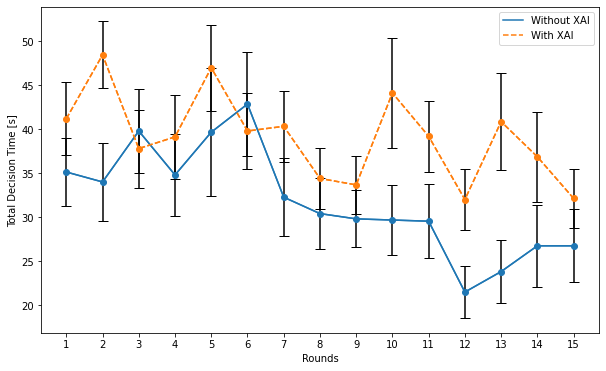

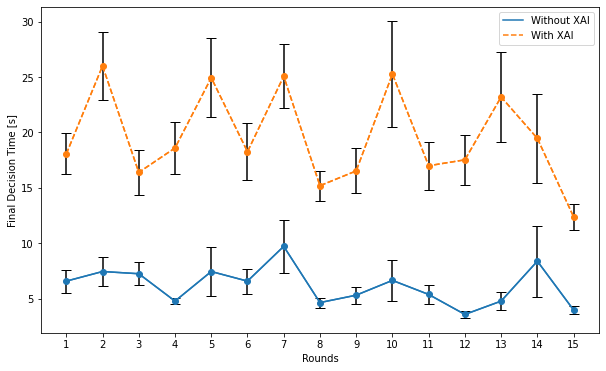

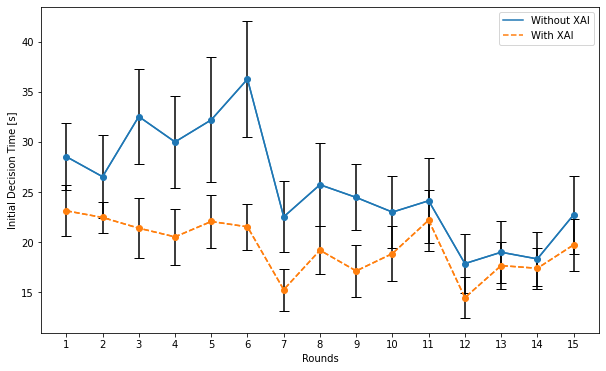

In [22]:
import numpy as np
import pandas as pd

decision_times = pd.read_csv('decision_times.csv')
decision_times['total_decision_time'] = decision_times['human_decision_time'] + decision_times['human_ai_decision_time']

decision_times_o = decision_times[decision_times['XAI_value'] == 0]
decision_times_ox = decision_times[decision_times['XAI_value'] == 1]

ai_decision_time_o = decision_times_o['human_ai_decision_time']
ai_decision_time_ox = decision_times_ox['human_ai_decision_time']

human_decision_time_o = decision_times_o['human_decision_time']
human_decision_time_ox = decision_times_ox['human_decision_time']

# calculate mean and std of each task (global decision time)
mean_o = decision_times_o.groupby('task')['total_decision_time'].mean()
sem_o = decision_times_o.groupby('task')['total_decision_time'].std(ddof=1) / np.sqrt(decision_times_o.groupby('task')['total_decision_time'].count())
mean_ox = decision_times_ox.groupby('task')['total_decision_time'].mean()
sem_ox = decision_times_ox.groupby('task')['total_decision_time'].std(ddof=1) / np.sqrt(decision_times_ox.groupby('task')['total_decision_time'].count())

# ai-human decision time
mean_ai_o = decision_times_o.groupby('task')['human_ai_decision_time'].mean()
sem_ai_o = decision_times_o.groupby('task')['human_ai_decision_time'].std(ddof=1) / np.sqrt(decision_times_o.groupby('task')['human_ai_decision_time'].count())
mean_ai_ox = decision_times_ox.groupby('task')['human_ai_decision_time'].mean()
sem_ai_ox = decision_times_ox.groupby('task')['human_ai_decision_time'].std(ddof=1) / np.sqrt(decision_times_ox.groupby('task')['human_ai_decision_time'].count())


# human decision time
mean_human_o = decision_times_o.groupby('task')['human_decision_time'].mean()
sem_human_o = decision_times_o.groupby('task')['human_decision_time'].std(ddof=1) / np.sqrt(decision_times_o.groupby('task')['human_decision_time'].count())
mean_human_ox = decision_times_ox.groupby('task')['human_decision_time'].mean()
sem_human_ox = decision_times_ox.groupby('task')['human_decision_time'].std(ddof=1) / np.sqrt(decision_times_ox.groupby('task')['human_decision_time'].count())

plt.figure(figsize=(10, 6))
positions = range(1, 16)
plt.errorbar(positions, mean_o, sem_o, color='tab:blue', ls='-', marker='o', capsize=5, capthick=1, ecolor='black')
plt.errorbar(positions, mean_ox, sem_ox, color='tab:orange', marker = 'o', ls = '--', capsize=5, capthick=1, ecolor='black')
plt.plot(positions, mean_o, color='tab:blue', linestyle = '-')
plt.plot(positions, mean_ox, color='tab:orange', linestyle = '--')

# Add legend for markers "s" and "P" only once
handles = [
        plt.Line2D([], [], color='tab:blue', linestyle='-', label='Without XAI'),
        plt.Line2D([], [], color='tab:orange', linestyle='--', label='With XAI'),
    ]

plt.legend(handles=handles)
plt.ylabel('Total Decision Time [s]')
plt.xlabel('Rounds')
plt.xticks(positions)
plt.savefig('global_decision_time_plot.pdf', dpi = 600, bbox_inches='tight')
plt.show()

plt.figure(figsize=(10, 6))
plt.errorbar(positions, mean_ai_o, sem_ai_o, color='tab:blue', ls='-', marker='o', capsize=5, capthick=1, ecolor='black')
plt.errorbar(positions, mean_ai_ox, sem_ai_ox, color='tab:orange', marker = 'o', ls = '--', capsize=5, capthick=1, ecolor='black')
plt.plot(positions, mean_ai_o, color='tab:blue', linestyle = '-')
plt.plot(positions, mean_ai_ox, color='tab:orange', linestyle = '--')

# Add legend for markers "s" and "P" only once
handles = [
        plt.Line2D([], [], color='tab:blue', linestyle='-', label='Without XAI'),
        plt.Line2D([], [], color='tab:orange', linestyle='--', label='With XAI'),
    ]
plt.legend(handles=handles)
plt.ylabel('Final Decision Time [s]')
plt.xlabel('Rounds')
plt.xticks(positions)
plt.savefig('ai_decision_time_box_plot.pdf', dpi = 600, bbox_inches='tight')
plt.show()

plt.figure(figsize=(10, 6))
plt.errorbar(positions, mean_human_o, sem_human_o, color='tab:blue', ls='-', marker='o', capsize=5, capthick=1, ecolor='black')
plt.errorbar(positions, mean_human_ox, sem_human_ox, color='tab:orange', marker = 'o', ls = '--', capsize=5, capthick=1, ecolor='black')
plt.plot(positions, mean_human_o, color='tab:blue', linestyle = '-')
plt.plot(positions, mean_human_ox, color='tab:orange', linestyle = '--')

# Add legend for markers "s" and "P" only once
handles = [
        plt.Line2D([], [], color='tab:blue', linestyle='-', label='Without XAI'),
        plt.Line2D([], [], color='tab:orange', linestyle='--', label='With XAI'),
    ]

plt.legend(handles=handles)
plt.ylabel('Initial Decision Time [s]')
plt.xlabel('Rounds')
plt.xticks(positions)
plt.savefig('human_decision_time_box_plot.pdf', dpi = 600, bbox_inches='tight')




### DATA MELTED NEW CAT

0      0
1      0
2      0
3      0
4      0
      ..
445    0
446    0
447    0
448    0
449    0
Name: Reliance_Alone, Length: 450, dtype: int64


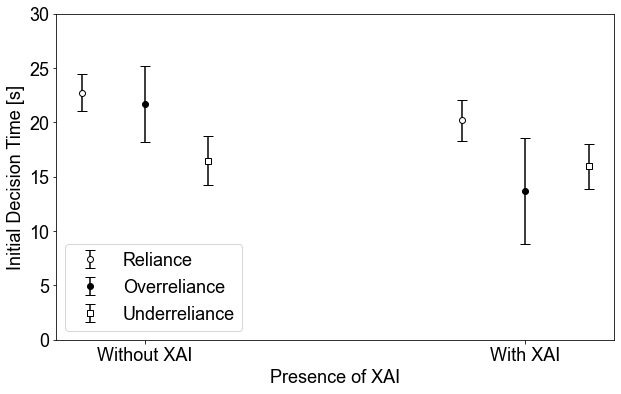

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

data_melted = pd.read_csv('data_melted_new_cat.csv')

over = data_melted[data_melted.overreliance==1][['XAI',
                                          'HTime']].groupby(['XAI']).agg(['mean','sem']).reset_index().melt(id_vars='XAI',var_name=['Metric','Measure'])
over.replace({'HTime':'Overreliance'}, inplace=True)

under = data_melted[data_melted.underreliance==1][['XAI',
                                          'HTime']].groupby(['XAI']).agg(['mean','sem']).reset_index().melt(id_vars='XAI',var_name=['Metric','Measure'])
under.replace({'HTime':'Underreliance'}, inplace=True)

reliance = data_melted[data_melted.reliance==1][['XAI',
                                          'HTime']].groupby(['XAI']).agg(['mean','sem']).reset_index().melt(id_vars='XAI',var_name=['Metric','Measure'])
reliance.replace({'HTime':'Reliance'}, inplace=True)

matching = data_melted[data_melted.matching_decision==1][['XAI',
                                          'HTime']].groupby(['XAI']).agg(['mean','sem']).reset_index().melt(id_vars='XAI',var_name=['Metric','Measure'])
matching.replace({'HTime':'Matching Decision'}, inplace=True)

print(data_melted.Reliance_Alone)

only_reliance = data_melted[data_melted.Reliance_Alone ==1][['XAI', 
                                        'HTime']].groupby(['XAI']).agg(['mean','sem']).reset_index().melt(id_vars='XAI',var_name=['Metric','Measure'])

only_reliance.replace({'HTime':'Only Reliance'}, inplace=True)

# Create a barplot
labels = ['Reliance', 'Overreliance', 'Underreliance']
x = np.arange(len(labels))  # positions for each bar

plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 16

positions = [1, 4]
labels = ['Without XAI', 'With XAI']

y_index = [0.5, 3.5]
y_index_2 = [1, 4]
y_index_3 = [1.5, 4.5]

plt.figure(figsize=(10, 6))

# font 
plt.rcParams.update({'font.size': 18})


# Reliance in XAI = True and False
plt.errorbar(y_index, [only_reliance['value'][0], only_reliance['value'][1]], yerr=[reliance['value'][2], only_reliance['value'][3]], \
             color='black', marker = 'o', markeredgecolor = 'black', markerfacecolor = 'white', ls = 'none', capsize=5, capthick=1, ecolor='black', label = 'Reliance')


# Overreliance in XAI = True and False
plt.errorbar(y_index_2, [over['value'][0], over['value'][1]],\
                [over['value'][2], over['value'][3]], \
             markeredgecolor = 'black', color='black', marker = 'o', ls='none', capsize=5, capthick=1, ecolor='black', label = 'Overreliance')

# Underreliance in XAI = True and False
plt.errorbar(y_index_3, [under['value'][0], under['value'][1]],\
                [under['value'][2], under['value'][3]], \
             markeredgecolor = 'black', color='black', markerfacecolor = 'white', marker='s', ls='none', capsize=5, capthick=1, ecolor='black', label = 'Underreliance')

plt.legend()
plt.ylabel('Initial Decision Time [s]')
plt.xlabel('Presence of XAI')
plt.ylim(0, 30)
plt.xticks(positions, labels)
plt.savefig('initial_decision_by_groups_boxplot.pdf', dpi = 600, bbox_inches='tight')
plt.show()





In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

decision_times = pd.read_csv('data_melted_new_cat.csv')
total_decision_time = decision_times['HTime'] + decision_times['HAITime']
initial_decision_time = decision_times['HTime']
final_decision_time = decision_times['HAITime']

decision_times_o = decision_times[decision_times['XAI'] == False]
decision_times_ox = decision_times[decision_times['XAI'] == True]


# save the results to a csv file
merged_data.to_csv('decision_times_groups.csv', index=False)

merged_data = pd.read_csv('decision_times_groups.csv')
global_results = pd.read_csv('decision_times_global_results.csv')

reliance_o = merged_data[merged_data['condition_reliance'] == 0]
reliance_ox = merged_data[merged_data['condition_reliance'] == 1]
overreliance_o = merged_data[merged_data['condition_overreliance'] == 0]
overreliance_ox = merged_data[merged_data['condition_overreliance'] == 1]
underreliance_o = merged_data[merged_data['condition_underreliance'] == 0]
underreliance_ox = merged_data[merged_data['condition_underreliance'] == 1]
no_underreliance_o = merged_data[merged_data['condition_underreliance'] == 11]
no_underreliance_ox = merged_data[merged_data['condition_underreliance'] == 10]
matching_o = merged_data[merged_data['condition_matching_decision'] == 0]
matching_ox = merged_data[merged_data['condition_matching_decision'] == 1]

def mean(df, column):
    mean = df[column].mean()
    return mean
def sem(df, column):
    sem = df[column].std(ddof=1) / np.sqrt(len(df))
    return sem

reliance_o_mean = mean(reliance_o, 'human_decision_time')
reliance_o_sem = sem(reliance_o, 'human_decision_time')
reliance_ox_mean = mean(reliance_ox, 'human_decision_time')
reliance_ox_sem = sem(reliance_ox, 'human_decision_time')

overreliance_o_mean = mean(overreliance_o, 'human_decision_time')
overreliance_o_sem = sem(overreliance_o, 'human_decision_time')
overreliance_ox_mean = mean(overreliance_ox, 'human_decision_time')
overreliance_ox_sem = sem(overreliance_ox, 'human_decision_time')

underreliance_o_mean = mean(underreliance_o, 'human_decision_time')
underreliance_o_sem = sem(underreliance_o, 'human_decision_time')
underreliance_ox_mean = mean(underreliance_ox, 'human_decision_time')
underreliance_ox_sem = sem(underreliance_ox, 'human_decision_time')

no_underreliance_o_mean = mean(no_underreliance_o, 'human_decision_time')
no_underreliance_o_sem = sem(no_underreliance_o, 'human_decision_time')
no_underreliance_ox_mean = mean(no_underreliance_ox, 'human_decision_time')
no_underreliance_ox_sem = sem(no_underreliance_ox, 'human_decision_time')

matching_o_mean = mean(matching_o, 'human_decision_time')
matching_o_sem = sem(matching_o, 'human_decision_time')
matching_ox_mean = mean(matching_ox, 'human_decision_time')
matching_ox_sem = sem(matching_ox, 'human_decision_time')

positions = [1.5, 9.5]
labels = ['Without XAI', 'With XAI']


y_index = [0.5, 8.5]
y_index_2 = [1, 9]
y_index_3 = [1.5, 9.5]
y_index_4 = [2, 10]

plt.figure(figsize=(10, 6))

# Reliance in XAI = True and False
plt.errorbar(y_index, [reliance_o_mean, reliance_ox_mean],\
              [reliance_o_sem, reliance_ox_sem], \
             color='black', marker = 'o', markeredgecolor = 'black', markerfacecolor = 'white', ls = 'none', capsize=5, capthick=1, ecolor='black', label = 'Reliance')

# Overreliance in XAI = True and False
plt.errorbar(y_index_2, [overreliance_o_mean, overreliance_ox_mean],\
                [overreliance_o_sem, overreliance_ox_sem], \
             markeredgecolor = 'black', color='black', marker = 'o', ls='none', capsize=5, capthick=1, ecolor='black', label = 'Overreliance')

# Underreliance in XAI = True and False
plt.errorbar(y_index_3, [underreliance_o_mean, underreliance_ox_mean],\
                [underreliance_o_sem, underreliance_ox_sem], \
             markeredgecolor = 'black', color='black', markerfacecolor = 'white', marker='s', ls='none', capsize=5, capthick=1, ecolor='black', label = 'Underreliance')

# Matching in XAI = True and False
plt.errorbar(y_index_4, [matching_o_mean, matching_ox_mean],\
                 [matching_o_sem, matching_ox_sem], \
             markeredgecolor = 'black', color='black', marker = 'v', ls='none', capsize=5, capthick=1, ecolor='black', label = 'Matching Decisions')

plt.legend()
plt.ylabel('Human Decision Time [s]')
plt.xlabel('Presence of XAI')
plt.xticks(positions, labels)
plt.savefig('human_decision_by_groups_boxplot.pdf', dpi = 600, bbox_inches='tight')
plt.show()

